In [1]:
import os
import warnings
from tqdm import tqdm
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

import scipy.signal
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
from scipy import signal
import concurrent.futures

# Rebuild the font cache
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
warnings.simplefilter("ignore", UserWarning)  # Ignores only UserWarnings

In [14]:
data_loc = Path("2024-AGU")
nerc_gic = data_loc / 'nerc' /'gic'
nerc_mag_folder = data_loc / 'nerc' / 'mag'

tva_folder = data_loc / "tva"
tva_gic = tva_folder / "gic"
tva_mag = tva_folder / "mag"

figures_dir = Path("__file__").resolve().parent / "figures"
figures_dir.mkdir(exist_ok=True)

## Magnetic field comparison

In [3]:
# Re usable codes

# Haversine distance to better match the subs
def haversine_dist(lat1, lon1, lat2, lon2):
    R = 6371
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def get_matches_df(gdf_mean_sim, gdf_monitors, threshold=2, op="nerc"):
    sim_lats = gdf_mean_sim["latitude"].to_numpy()
    sim_lons = gdf_mean_sim["longitude"].to_numpy()
    mon_lats = gdf_monitors["latitude"].to_numpy()
    mon_lons = gdf_monitors["longitude"].to_numpy()

    # Compute pairwise distances (shape: [n_sim, n_mon])
    dists = haversine_dist(sim_lats[:, None], sim_lons[:, None],
                                 mon_lats[None, :], mon_lons[None, :])
    sim_idx, mon_idx = np.nonzero(dists <= threshold)
    
    monitor_field = "Device ID" if op == "nerc" else "Name"
    
    df = pd.DataFrame({
        "substation":   gdf_mean_sim.iloc[sim_idx]["sub_id"].to_numpy(),
        "sub_lat":      gdf_mean_sim.iloc[sim_idx]["latitude"].to_numpy(),
        "sub_lon":      gdf_mean_sim.iloc[sim_idx]["longitude"].to_numpy(),
        "monitor_name": gdf_monitors.iloc[mon_idx][monitor_field].to_numpy(),
        "monitor_lat":  gdf_monitors.iloc[mon_idx]["latitude"].to_numpy(),
        "monitor_lon":  gdf_monitors.iloc[mon_idx]["longitude"].to_numpy(),
    })
    
    return df.drop_duplicates(["substation", "monitor_name"])

# Function to detrend and handle missing values
def preprocess_magnetic_field(ds):
    for comp in ["Bx", "By", "Bz"]:
        if comp in ds:
            # Fill missing values with backward fill and interpolation
            ds[comp] = ds[comp].bfill(dim="time").interpolate_na(dim="time")

            ds[comp] = ds[comp].where(np.isfinite(ds[comp]), other=np.nan)
            
            # Fill missing values along time dimension:
            ds[comp] = ds[comp].ffill(dim="time").interpolate_na(dim="time", method="linear")
            
            # Detrend the data
            ds[comp] = xr.DataArray(
                scipy.signal.detrend(ds[comp], axis=0),
                dims=ds[comp].dims,
                coords=ds[comp].coords,
            )
    return ds

In [4]:
# NERC
# Read the magnetic data
if os.path.exists(data_loc / "nerc_magnetometer_data.nc"):
    ds_mag_nerc = xr.open_dataset(data_loc / "nerc_magnetometer_data.nc")

else:
    # glob files if start with 2024*.csv
    nerc_mag_files = list(nerc_mag_folder.glob('2024*.csv'))
    
    # Read magnetic data locs
    nerc_mag_locs_df = pd.read_csv(nerc_mag_folder / "magnetometers.csv")
    
    # Rename columns removing white spaces
    nerc_mag_locs_df.rename(
        columns={
            "Device ID": "device_id",
            " Latitude": "latitude",
            " Longitude": "longitude",
            " Orientation": "orientation",
        },
        inplace=True,
    )
    
    # Filter out only geographic coordinates
    nerc_mag_locs_df = nerc_mag_locs_df[nerc_mag_locs_df["orientation"] == "1 - Geographic"].copy()
    
    # Since in US, longitude is negative, we need to adjust
    nerc_mag_locs_df["longitude"] = nerc_mag_locs_df["longitude"].apply(
        lambda x: -x if x > 0 and x > 60 else x
    )
    
    # Some orientations are geographic while others are geomagnetic
    df_list = [pd.read_csv(f) for f in nerc_mag_files]
    nerc_mag_df = pd.concat(df_list, ignore_index=True)
    
    # Rename columns for consistency
    nerc_mag_df.rename(
        columns={
            "MagnetometerDeviceID": "device_id",
            "SampleDateTime": "time",
            "GeoBfieldMeasureNorth": "Bx",
            "GeoBfieldMeasureEast": "By",
            "GeoBfieldMeasureVertical": "Bz",
        },
        inplace=True,
    )
    
    # Convert time column to datetime format
    nerc_mag_df["time"] = pd.to_datetime(nerc_mag_df["time"], format="%m/%d/%Y %I:%M:%S %p")
    
    # Merge with magnetometer locations data to get latitude, longitude, and orientation
    nerc_mag_df = nerc_mag_df.merge(nerc_mag_locs_df, on="device_id", how="inner")
    
    # %%
    # Convert to xarray Dataset
    ds_mag_nerc = xr.Dataset(
        {
            "Bx": (
                ["time", "device"],
                nerc_mag_df.pivot(index="time", columns="device_id", values="Bx").values,
            ),
            "By": (
                ["time", "device"],
                nerc_mag_df.pivot(index="time", columns="device_id", values="By").values,
            ),
            "Bz": (
                ["time", "device"],
                nerc_mag_df.pivot(index="time", columns="device_id", values="Bz").values,
            ),
        },
        coords={
            "time": nerc_mag_df["time"].unique(),
            "device": nerc_mag_df["device_id"].unique(),
            "latitude": (
                ["device"],
                nerc_mag_df.drop_duplicates("device_id")
                .set_index("device_id")["latitude"]
                .values,
            ),
            "longitude": (
                ["device"],
                nerc_mag_df.drop_duplicates("device_id")
                .set_index("device_id")["longitude"]
                .values,
            ),
            "orientation": (
                ["device"],
                nerc_mag_df.drop_duplicates("device_id")
                .set_index("device_id")["orientation"]
                .values,
            ),
        },
    )

    ds_mag_nerc = ds_mag_nerc.sortby('time')
    
    # Apply preprocessing
    ds_mag_nerc = preprocess_magnetic_field(ds_mag_nerc)
    
    # Save to NetCDF file
    ds_mag_nerc.to_netcdf(data_loc / "nerc_magnetometer_data.nc")

In [5]:
# Resample the NERC magnetometer data to one minute
ds_mag_nerc = ds_mag_nerc.resample(time='min').first()

# Read the magnetotelluric data from secs and bezpy
simulated_ds = xr.open_dataset(data_loc / "ds_gannon.nc")

# Rename site_x and site_y to latitude and longitude of the sim
simulated_ds = simulated_ds.rename({'site_x': 'latitude', 'site_y': 'longitude'})

In [6]:
# Process tva magnetometer data
processed_tva_mag = data_loc / "tva_magnetometer_data.nc"
if not os.path.exists(processed_tva_mag):
    # Read the tva mag info
    tva_mag_files =list(tva_mag.glob('*.csv'))
    
    # TVA mag metadata
    tvamag_meta_dat = pd.read_csv(tva_mag / "TVAmagmetadata.dat", names=["Device", "latitude", 'longitude'])
    
    # Map file prefix to proper site device
    device_map = {
        "ackerman": "Ackerman",
        "bullrun": "Bull Run",
        "lagooncreek": "Lagoon Creek",
        "paradise": "Paradise",
        "raccoonmountain": "Raccoon Mountain",
        "union": "Union",
        "wattsbar": "Watts Bar"
    }
    
    # Read CSVs, rename columns, and assign site devices
    dfs = []
    for f in tva_mag_files:
        df = pd.read_csv(f, parse_dates=["datetime"])
        df = df.rename(columns={"x": "Bx", "y": "By", "z": "Bz"})
        key = f.stem.split("_")[0].lower()
        df["device"] = device_map.get(key, key)
        dfs.append(df)
    
    tva_mag_df = pd.concat(dfs, ignore_index=True)
    tva_mag_df = tva_mag_df.merge(tvamag_meta_dat, left_on="device", right_on="Device", how="left")
    
    # Create xarray Dataset using original Bx, By, Bz; no orientation
    ds_tva_mag = xr.Dataset(
        {
            "Bx": (["time", "device"],
                   tva_mag_df.pivot(index="datetime", columns="device", values="Bx").values),
            "By": (["time", "device"],
                   tva_mag_df.pivot(index="datetime", columns="device", values="By").values),
            "Bz": (["time", "device"],
                   tva_mag_df.pivot(index="datetime", columns="device", values="Bz").values),
        },
        coords={
            "time": tva_mag_df["datetime"].unique(),
            "device": tva_mag_df["device"].unique(),
            "latitude": (["device"],
                         tva_mag_df.drop_duplicates("device").set_index("device")["latitude"].values),
            "longitude": (["device"],
                          tva_mag_df.drop_duplicates("device").set_index("device")["longitude"].values),
        }
    )
    # Apply preprocessing
    ds_tva_mag = preprocess_magnetic_field(ds_tva_mag)
    
    # Save tva nc file
    ds_tva_mag.to_netcdf(processed_tva_mag)
else:
    ds_tva_mag = xr.open_dataset(processed_tva_mag)
# Resample the ds to one min
ds_tva_mag = ds_tva_mag.resample(time='min').first()

In [7]:
def get_close_mag_sites(ds_operator, ds_sim, threshold = 100):
    
    ds_op_lat, ds_op_lon = ds_operator.latitude.values, ds_operator.longitude.values
    ds_sim_lat, ds_sim_lon = ds_sim.latitude.values, ds_sim.longitude.values

    # Compute pairwise distances (in km) using vectorized haversine
    dists = haversine_dist(ds_op_lat[:, None], ds_op_lon[:, None],
                                 ds_sim_lat[None, :], ds_sim_lon[None, :])

    # For each GIC station, select the closest MT site within the threshold and record its distance
    closest_mt_sites = []
    closest_distances = []
    for row in dists:
        valid = np.where(row <= threshold)[0]
        if valid.size:
            idx = valid[np.argmin(row[valid])]
            closest_mt_sites.append(idx)
            closest_distances.append(row[idx])
        else:
            closest_mt_sites.append(np.nan)
            closest_distances.append(np.nan)
    
    ds_operator = ds_operator.assign_coords(
        nearest_mt_site=("device", closest_mt_sites),
        nearest_distance=("device", closest_distances)
    )
    
    # Sort by nearest_distance (from smallest to largest)
    return ds_operator.sortby("nearest_distance")

In [8]:
def prepare_data_for_viz(ds_mag, ds_mt, sites=None, n_sites=4):
    
    # Determine overlapping time range
    mag_time_range = ds_mag.time.values
    mt_time_range = ds_mt.time.values
    start_time = max(mag_time_range[0], mt_time_range[0])
    end_time = min(mag_time_range[-1], mt_time_range[-1])
    
    ds_mag_sliced = ds_mag.sel(time=slice(start_time, end_time))
    ds_mt_sliced = ds_mt.sel(time=slice(start_time, end_time))
    times = pd.to_datetime(ds_mag_sliced.time.values)
    try:
        mt_names = ds_mt.name.values
    except AttributeError:
        mt_names = ds_mt.device.values
    
    # Filter stations with valid nearest MT sites
    valid = ~np.isnan(ds_mag_sliced.nearest_mt_site.values)
    if sites is not None:
        valid &= np.isin(ds_mag_sliced.device.values, sites)
    
    mag_stations = ds_mag_sliced.device.values[valid]
    mt_indices = ds_mag_sliced.nearest_mt_site.values[valid].astype(int)
    
    if len(mag_stations) == 0:
        raise ValueError("No valid magnetometer stations with matching MT sites found")
    
    n_sites = min(n_sites, len(mag_stations))
    mag_stations = mag_stations[:n_sites]
    mt_indices = mt_indices[:n_sites]
    
    return ds_mag_sliced, ds_mt_sliced, times, mag_stations, mt_indices, n_sites, mt_names

In [9]:
# Make figures dir
os.makedirs("dennies_figs", exist_ok=True)

In [201]:
def plot_magnetic_field_comparison(ds_mag, simulated_ds, threshold=30, title_1="", title_2="", output_path=None, op_2_op_comparison=False):
    
    # Select close magnetometer sites and prepare data
    ds_mag_close = get_close_mag_sites(ds_mag, simulated_ds, threshold=threshold)
    (ds_mag_sliced, ds_mt_sliced, times, mag_stations, 
     mt_indices, n_sites, mt_names) = prepare_data_for_viz(ds_mag_close, simulated_ds)
    
    # Create figure: 2 rows per site (one for field components, one for residuals) and 2 columns (Bx, By)
    fig, axes = plt.subplots(nrows=2 * n_sites, ncols=2, figsize=(9, 12), sharex=True)
    
    # Labels and plot styles
    magnetic_plots = [r"Measured $\Delta B$", r"Predicted $\Delta B$", r"Res $\Delta B$"]

    if op_2_op_comparison:
        magnetic_plots = [r"NERC $\Delta B$", r"TVA $\Delta B$", r"Res $\Delta B$"]
    colors = ['darkred', 'darkblue', '#E69F00']
    line_types = ["-", "--", "-"]
    
    # Loop over sites (only process up to n_sites)
    for site_idx, (mag_station, mt_idx) in enumerate(list(zip(mag_stations, mt_indices))[:n_sites]):
        # Set up axes for B components and residuals
        ax1_x = axes[2 * site_idx, 0]     # Bx components (left)
        ax1_y = axes[2 * site_idx, 1]     # By components (right)
        ax2_x = axes[2 * site_idx + 1, 0] # Bx residuals (left)
        ax2_y = axes[2 * site_idx + 1, 1] # By residuals (right)
        
        mt_idx = int(mt_idx)
        mag_lat = ds_mag_close.latitude.sel(device=mag_station).values
        mag_lon = ds_mag_close.longitude.sel(device=mag_station).values
        try:
            mt_lat = simulated_ds.latitude.isel(latitude=mt_idx).values
            mt_lon = simulated_ds.longitude.isel(longitude=mt_idx).values
        except ValueError:
            mt_lat = simulated_ds.latitude.isel(device=mt_idx).values
            mt_lon = simulated_ds.longitude.isel(device=mt_idx).values
        mt_name = mt_names[mt_idx]
        dist = ds_mag_close.nearest_distance.sel(device=mag_station).values
        
        try:
            # Get measured and simulated components for the site
            mag_Bx = ds_mag_sliced.Bx.sel(device=mag_station).values
            mag_By = ds_mag_sliced.By.sel(device=mag_station).values
            if op_2_op_comparison:
                mt_Bx = ds_mt_sliced.Bx.isel(device=mt_idx).values
                mt_By = ds_mt_sliced.By.isel(device=mt_idx).values
            else:
                mt_Bx = ds_mt_sliced.B_pred.sel(site=mt_idx, component="Bx").values
                mt_By = ds_mt_sliced.B_pred.sel(site=mt_idx, component="By").values

            # Plot measured and simulated Bx
            ax1_x.plot(times, mag_Bx, c=colors[0], linewidth=0.8)
            ax1_x.plot(times, mt_Bx, c=colors[1], linewidth=0.6, linestyle=line_types[1])
            ax1_x.set_ylabel(r"$\Delta B_x$ (nT)")
            ax1_x.axhline(0.0, c="gray", linewidth=0.5)

            # Plot measured and simulated By
            ax1_y.plot(times, mag_By, c=colors[0], linewidth=0.8)
            ax1_y.plot(times, mt_By, c=colors[1], linewidth=0.6, linestyle=line_types[1])
            ax1_y.set_ylabel(r"$\Delta B_y$ (nT)")
            ax1_y.axhline(0.0, c="gray", linewidth=0.5)

            # Plot residuals for Bx and By
            ax2_x.plot(times, mt_Bx - mag_Bx, c=colors[2], linewidth=0.5)
            ax2_x.set_ylabel(r"$\Delta B_x$ (nT)")
            ax2_x.axhline(0.0, c="gray", linewidth=0.5)

            ax2_y.plot(times, mt_By - mag_By, c=colors[2], linewidth=0.5)
            ax2_y.set_ylabel(r"$\Delta B_y$ (nT)")
            ax2_y.axhline(0.0, c="gray", linewidth=0.5)

            # Add annotations and titles to the top axes
            # ax1_x.text(0.8, 1.25, f'({chr(97 + 2*site_idx)}) Site {mt_name} (Mag: {mag_station})', 
            #            transform=ax1_x.transAxes, fontsize=10, fontweight='bold')
            # ax1_x.text(0.8, 1.1, 
            #            f'Monitor: ({mag_lat:.2f}°, {mag_lon:.2f}°), MT: ({mt_lat:.2f}°, {mt_lon:.2f}°), '
            #            f'Dist: {int(dist):.2f} km', 
            #            transform=ax1_x.transAxes, fontsize=8)
            ax1_x.text(0.8, 1.3, f'({chr(97+site_idx)}) {title_2} Site {mt_names[mt_idx]} (Magnetometer: {mag_station})', 
                transform=ax1_x.transAxes, fontsize=12, fontweight='bold')
            ax1_x.text(0.8, 1.1, f'{title_1} Monitor: ({mag_lat:.2f}°, {mag_lon:.2f}°), MT Site: ({mt_lat:.2f}°, {mt_lon:.2f}°), Distance: {int(dist):.2f} km', 
                transform=ax1_x.transAxes, fontsize=10)
        
            # Residuals labels
            ax2_x.text(0, 1.2, "Residuals $B_x$", transform=ax2_x.transAxes, fontsize=11, fontweight='bold')
            ax2_y.text(0, 1.2, "Residuals $B_y$", transform=ax2_y.transAxes, fontsize=11, fontweight='bold')
            ax2_x.text(0, 1.05, "Measured - Predicted $B_x$", transform=ax2_x.transAxes, fontsize=10)
            ax2_y.text(0, 1.05, "Measured - Predicted $B_y$", transform=ax2_y.transAxes, fontsize=10)
        except Exception as e:
            print(f"Error plotting site {mag_station}: {e}")
            continue

    # Create legend for the upper subplots (only once)
    legend_elements = [Line2D([0], [0], linestyle=line_types[i], color=colors[i],
                              label=label) for i, label in enumerate(magnetic_plots)]
    axes[-1, 0].legend(handles=legend_elements, loc='lower center', ncol=len(magnetic_plots) + 1,
                       frameon=False, bbox_to_anchor=(1.1, -0.9), alignment='left')

    # Set common x-axis limits and ticks
    for ax in axes[-1, :]:
        ax.set_xlim(times[0], times[-1])
        tick_positions = np.linspace(0, len(times)-1, 6, dtype=int)
        tick_times = [times[i] for i in tick_positions]
        ax.set_xticks(tick_times)
        ax.set_xticklabels([t.strftime("%H:%M\n%m/%d") for t in tick_times])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.20, hspace=0.6)

    if output_path:
        fig.savefig(output_path, dpi=300)

    plt.show()
    return fig

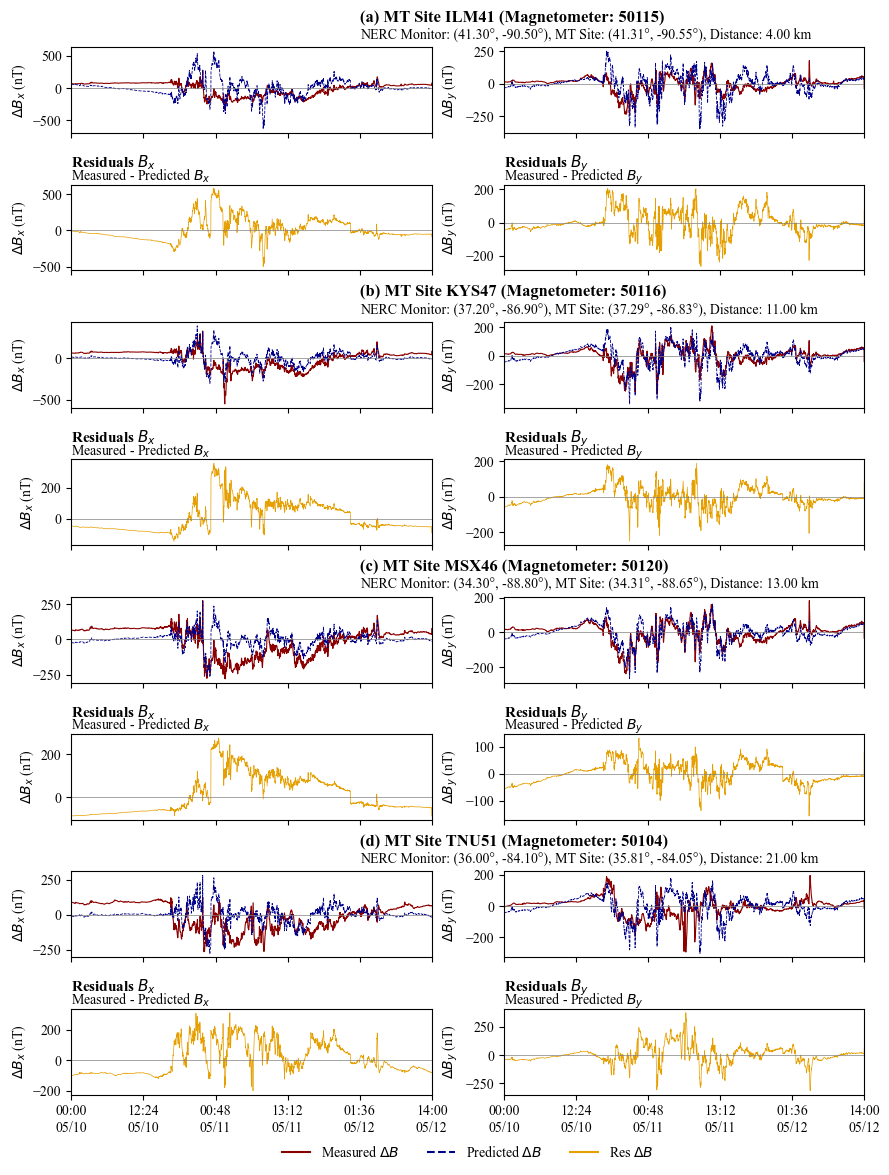

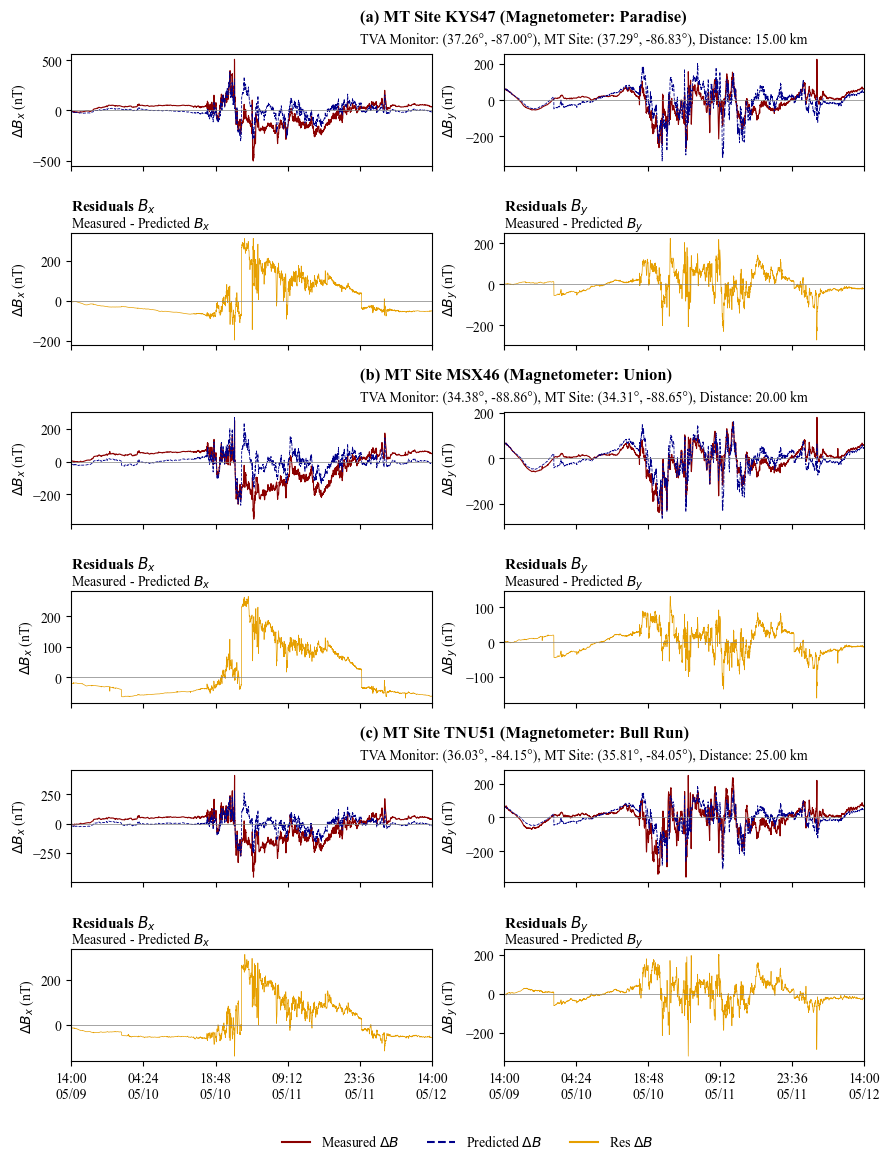

In [202]:
# For NERC data:
fig_nerc = plot_magnetic_field_comparison(ds_mag_nerc, simulated_ds, threshold=30,
                                            title_1="NERC",
                                            title_2="MT",
                                            output_path=figures_dir/"nerc_comparison.png")

# For TVA data:
fig_tva = plot_magnetic_field_comparison(ds_tva_mag, simulated_ds, threshold=30,
                                            title_1="TVA",
                                            title_2="MT",
                                           output_path=figures_dir/"tva_comparison.png")

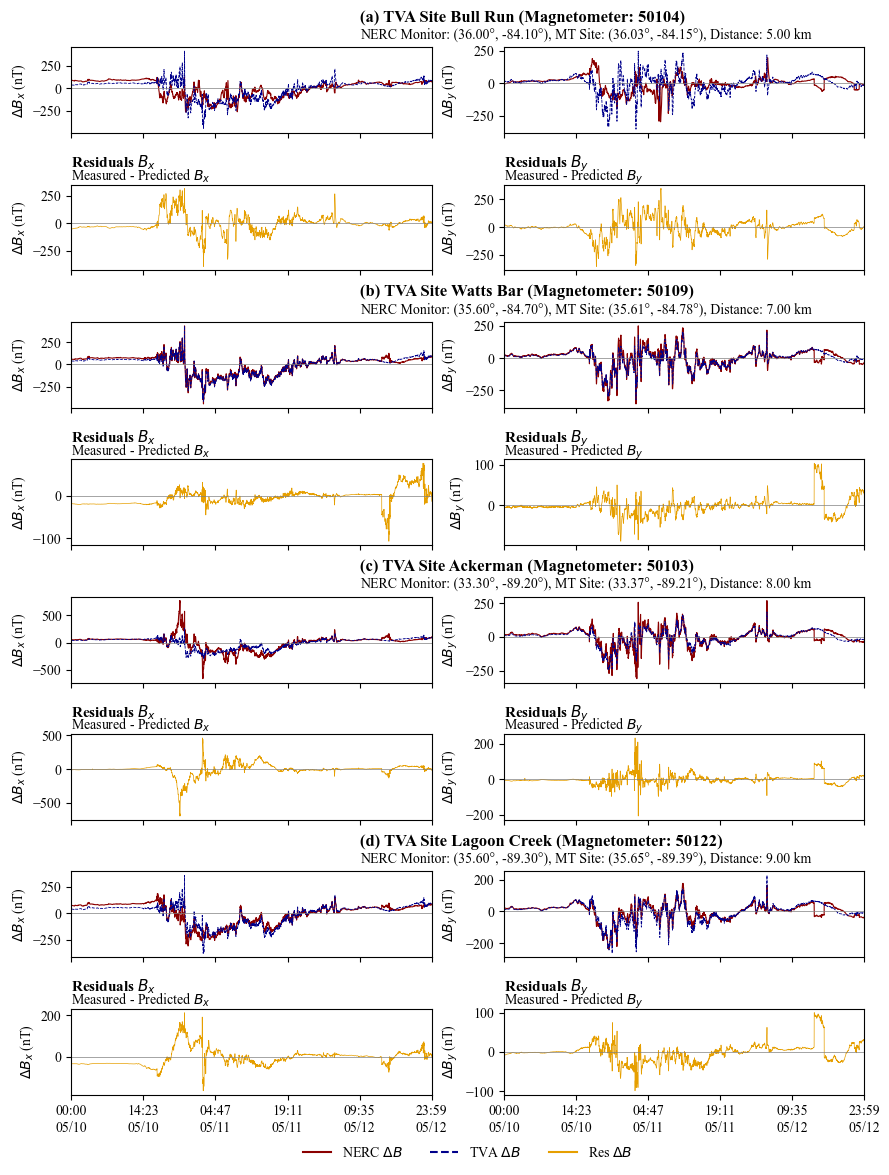

In [203]:
# TVA vs NERC
fig_nerc_tva = plot_magnetic_field_comparison(ds_mag_nerc, ds_tva_mag, threshold=30,
                                            title_1="NERC",
                                            title_2="TVA",
                                            output_path=figures_dir / "nerc_tva_comparison.png", op_2_op_comparison=True)

In [204]:
# Find close distances btween 3 datasets TVA, NERC and Simulated
def find_pairwise_matches(ds_primary, ds_other, threshold=100):
    prim_lat = ds_primary.latitude.values
    prim_lon = ds_primary.longitude.values
    other_lat = ds_other.latitude.values
    other_lon = ds_other.longitude.values

    # Compute the pairwise distances (assumes haversine_dist is defined)
    dists = haversine_dist(prim_lat[:, None], prim_lon[:, None],
                           other_lat[None, :], other_lon[None, :])
    
    match_ids = []
    match_dists = []
    for row in dists:
        valid = np.where(row <= threshold)[0]
        if valid.size:
            idx = valid[np.argmin(row[valid])]
            match_ids.append(idx)
            match_dists.append(row[idx])
        else:
            match_ids.append(np.nan)
            match_dists.append(np.nan)
            
    return np.array(match_ids), np.array(match_dists)

def get_common_sites(ds_primary, ds_secondary, ds_tertiary, threshold=100):
    sec_ids, sec_dists = find_pairwise_matches(ds_primary, ds_secondary, threshold)
    ter_ids, ter_dists = find_pairwise_matches(ds_primary, ds_tertiary, threshold)
    
    # A valid match in each case should not be NaN.
    valid = ~np.isnan(sec_ids) & ~np.isnan(ter_ids)
    
    # Assuming ds_primary has a coordinate (or variable) 'device'
    common_devices = ds_primary.device.values[valid]
    return (common_devices, sec_ids[valid].astype(int), ter_ids[valid].astype(int),
            sec_dists[valid], ter_dists[valid])

In [205]:
# Find close distances btween 3 datasets TVA, NERC and Simulated
def find_pairwise_matches(ds_primary, ds_other, threshold=100):
    prim_lat = ds_primary.latitude.values
    prim_lon = ds_primary.longitude.values
    other_lat = ds_other.latitude.values
    other_lon = ds_other.longitude.values

    # Compute the pairwise distances (assumes haversine_dist is defined)
    dists = haversine_dist(prim_lat[:, None], prim_lon[:, None],
                           other_lat[None, :], other_lon[None, :])
    
    match_ids = []
    match_dists = []
    for row in dists:
        valid = np.where(row <= threshold)[0]
        if valid.size:
            match_ids.append(valid)
            match_dists.append(row[valid])
        else:
            match_ids.append(np.nan)
            match_dists.append(np.nan)
            
    return np.array(match_ids, dtype=object), np.array(match_dists, dtype=object)

# Function to check if an entry is NaN or an empty list
def is_nan_or_empty(entry):
    return entry is np.nan or (isinstance(entry, (list, np.ndarray)) and len(entry) == 0)

def get_common_sites(ds_primary, ds_secondary, ds_tertiary, threshold=100):
    sec_ids, sec_dists = find_pairwise_matches(ds_primary, ds_secondary, threshold)
    ter_ids, ter_dists = find_pairwise_matches(ds_primary, ds_tertiary, threshold)
    
    # A valid match in each case should not be NaN.
    valid = np.array([not is_nan_or_empty(s) and not is_nan_or_empty(t) for s, t in zip(sec_ids, ter_ids)])
    
    common_devices = ds_primary.device.values[valid]
    return (common_devices, sec_ids[valid], ter_ids[valid],
            sec_dists[valid], ter_dists[valid])

In [206]:
ds_primary = ds_tva_mag.copy()
ds_secondary = simulated_ds.copy()
ds_tertiary = ds_mag_nerc.copy()

(common_devices, sec_ids, ter_ids, sec_dists, ter_dists) = get_common_sites(ds_primary, ds_secondary, ds_tertiary, threshold=50)

ter_time_range = ds_tertiary.time.values
sec_time_range = ds_secondary.time.values

start_time = max(ter_time_range[0], sec_time_range[0])
end_time = min(ter_time_range[-1], sec_time_range[-1])

ds_pri_sliced = ds_primary.sel(time=slice(start_time, end_time))
ds_sec_sliced = ds_secondary.sel(time=slice(start_time, end_time))
ds_ter_sliced = ds_tertiary.sel(time=slice(start_time, end_time))

In [207]:
ds_primary = ds_tva_mag.copy()
ds_secondary = simulated_ds.copy()
ds_tertiary = ds_mag_nerc.copy()

(common_devices, sec_ids, ter_ids, sec_dists, ter_dists) = get_common_sites(ds_primary, ds_secondary, ds_tertiary, threshold=50)

ter_time_range = ds_tertiary.time.values
sec_time_range = ds_secondary.time.values

start_time = max(ter_time_range[0], sec_time_range[0])
end_time = min(ter_time_range[-1], sec_time_range[-1])

ds_pri_sliced = ds_primary.sel(time=slice(start_time, end_time))
ds_sec_sliced = ds_secondary.sel(time=slice(start_time, end_time))
ds_ter_sliced = ds_tertiary.sel(time=slice(start_time, end_time))

os.makedirs(data_loc / "dbor" / "mag-comparison", exist_ok=True)

# Iterate through all sites
for site_idx, pri_dev in enumerate(common_devices):
    
    pri_Bx = ds_pri_sliced.Bx.sel(device=pri_dev).values
    pri_By = ds_pri_sliced.By.sel(device=pri_dev).values

    site_dict = {
        "timestamp": ds_pri_sliced.time.values,  # Time data
        "TVA Device": [pri_dev] * len(ds_pri_sliced.time.values),
        "TVA Bx": pri_Bx,
        "TVA By": pri_By,
        "TVA Latitude": [ds_pri_sliced.latitude.sel(device=pri_dev).values] * len(ds_pri_sliced.time.values),
        "TVA Longitude": [ds_pri_sliced.longitude.sel(device=pri_dev).values] * len(ds_pri_sliced.time.values)
    }

    # Loop through secondary devices
    for i, sec_idx in enumerate(sec_ids[site_idx]):
        sec_lat = ds_sec_sliced.latitude.isel(latitude=sec_idx).values
        sec_lon = ds_sec_sliced.longitude.isel(longitude=sec_idx).values
        sec_dev = ds_sec_sliced.name.isel(name=sec_idx).values
        sec_dist = sec_dists[site_idx][i]

        sec_Bx = ds_sec_sliced.B_pred.sel(site=sec_idx, component="Bx").values
        sec_By = ds_sec_sliced.B_pred.sel(site=sec_idx, component="By").values

        site_dict.update({
            f"MT_site_{i+1}_Device": [sec_dev] * len(sec_Bx),
            f"MT_site_{i+1}_Bx": sec_Bx,
            f"MT_site_{i+1}_By": sec_By,
            f"MT_site_{i+1}_Latitude": [sec_lat] * len(sec_Bx),
            f"MT_site_{i+1}_Longitude": [sec_lon] * len(sec_Bx),
            f"MT_site_{i+1}_Distance": [sec_dist] * len(sec_Bx)
        })

    # Loop through tertiary devices
    for i, ter_idx in enumerate(ter_ids[site_idx]):
        ter_lat = ds_ter_sliced.latitude.isel(device=ter_idx).values
        ter_lon = ds_ter_sliced.longitude.isel(device=ter_idx).values
        ter_dev = ds_ter_sliced.device.isel(device=ter_idx).values
        ter_dist = ter_dists[site_idx][i]

        ter_Bx = ds_ter_sliced.Bx.sel(device=ter_dev).values
        ter_By = ds_ter_sliced.By.sel(device=ter_dev).values

        site_dict.update({
            f"NERC_site_{i+1}_Device": [ter_dev] * len(ter_Bx),
            f"NERC_site_{i+1}_Bx": ter_Bx,
            f"NERC_site_{i+1}_By": ter_By,
            f"NERC_site_{i+1}_Latitude": [ter_lat] * len(ter_Bx),
            f"NERC_site_{i+1}_Longitude": [ter_lon] * len(ter_Bx),
            f"NERC_site_{i+1}_Distance": [ter_dist] * len(ter_Bx)
        })

    # Convert to DataFrame
    df = pd.DataFrame(site_dict)

    # Save DataFrame as CSV
    output_file = data_loc / "dbor" / "mag-comparison" / f"site_{pri_dev}.csv"
    df.to_csv(output_file, index=False)

In [208]:
from scipy.signal import welch, coherence, csd

# Example Bx field signals from two sites (replace with real data)
fs = 1/60  # Sampling frequency (1 sample per minute)
nperseg = 256  # 4.2 hours per segment
noverlap = 128  # 50% overlap
window = 'hann'  # Hann window

# Compute Welch PSD for both signals
f, Sx = welch(pri_Bx, fs=fs, nperseg=nperseg, noverlap=noverlap, window=window)
_, Sy = welch(sec_Bx, fs=fs, nperseg=nperseg, noverlap=noverlap, window=window)

# Compute Coherence
f_coh, Cxy = coherence(pri_Bx, sec_Bx, fs=fs, nperseg=nperseg, noverlap=noverlap, window=window)

# CSD
f, Pxy = csd(pri_Bx, sec_Bx, fs, nperseg=nperseg, noverlap=noverlap, window=window)

# # Plot Welch PSDs
# plt.figure(figsize=(8, 5))
# plt.semilogy(f, Sx, label='Site 1 Bx PSD')
# plt.semilogy(f, Sy, label='Site 2 Bx PSD')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectral Density')
# plt.title('Welch PSD of Bx Signals')
# plt.legend()
# plt.grid()
# plt.show()

# # Plot Coherence
# plt.figure(figsize=(8, 5))
# plt.plot(f_coh, Cxy, label='Coherence between Bx signals')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Coherence')
# plt.title('Coherence Analysis Between Bx Signals')
# plt.legend()
# plt.grid()
# plt.show()

# # Cross spectral density
# plt.figure(figsize=(8, 5))
# plt.plot(f, Pxy, label='CSF between Bx signals')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('CSD')
# plt.title('CSD Between Bx Signals')
# plt.legend()
# plt.grid()
# plt.show()

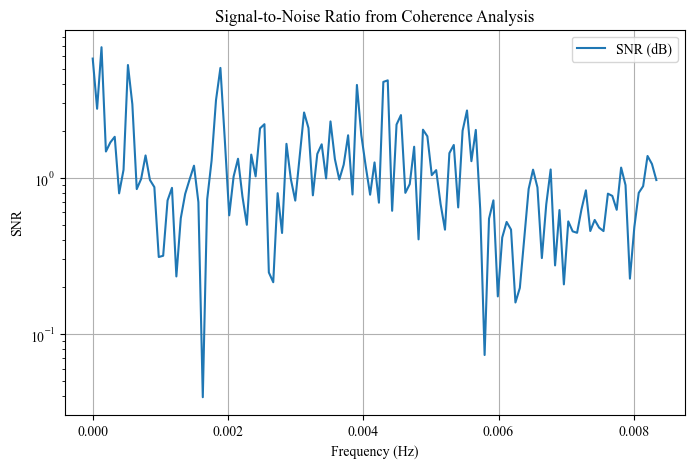

In [209]:
snr = Cxy / (1 - Cxy)

# Plot SNR
plt.figure(figsize=(8, 5))
plt.semilogy(f, snr, label='SNR (dB)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio from Coherence Analysis')
plt.legend()
plt.grid()
plt.show()

In [210]:
# n_sites = len(common_devices)

# ds_tva_sliced = ds_pri_sliced.copy()
# ds_mt_sliced = ds_sec_sliced.copy()
# ds_nerc_sliced = ds_ter_sliced.copy()

# # Create figure: 2 rows per site and 2 columns (Bx on left, By on right)
# fig, axes = plt.subplots(nrows=2 * n_sites, ncols=2, figsize=(9, 12), sharex=True)
# if n_sites == 1:
#     axes = axes.reshape(2, 2)

# # Labels, colors, and line styles for both field curves and residuals
# magnetic_plots = [r"NERC $\Delta B$", r"TVA $\Delta B$", r"Simulated $\Delta B$", 
#                   r"Res NERC-TVA $\Delta B$", r"Res TVA-Sim $\Delta B$", r"Res NERC-Sim $\Delta B$"]
# colors_all = colors = ['darkred', 'darkblue', "darkgreen", 'yellow', "#009E73", "violet"]
# line_types_all = ["-", "-", "-", "--", "-.", ":"]

# times = pd.to_datetime(ds_nerc_sliced.time.values)
# mt_names = ds_mt_sliced.name.values

# for site_idx in range(n_sites):
#     # Get the matching IDs and use maximum distance for annotation
#     nerc_dev = common_devices[site_idx]
#     sim_idx = sim_ids[site_idx]
#     tva_idx = tva_ids[site_idx]
#     dist = np.nanmax([sim_dists[site_idx], tva_dists[site_idx]])
    
#     # Set up axes for this site:
#     ax1_x = axes[2 * site_idx, 0]     # Bx components (top left)
#     ax1_y = axes[2 * site_idx, 1]     # By components (top right)
#     ax2_x = axes[2 * site_idx + 1, 0]  # Bx residuals (bottom left)
#     ax2_y = axes[2 * site_idx + 1, 1]  # By residuals (bottom right)
    
#     # Get locations from datasets
#     mag_lat = ds_nerc_sliced.latitude.sel(device=nerc_dev).values
#     mag_lon = ds_nerc_sliced.longitude.sel(device=nerc_dev).values
#     tva_device = ds_tva_sliced.device.values[tva_idx]
#     tva_lat = ds_tva_sliced.latitude.sel(device=tva_device).values
#     tva_lon = ds_tva_sliced.longitude.sel(device=tva_device).values
#     try:
#         sim_lat = ds_mt_sliced.latitude.isel(latitude=sim_idx).values
#         sim_lon = ds_mt_sliced.longitude.isel(longitude=sim_idx).values
#     except ValueError:
#         sim_lat = ds_mt_sliced.latitude.isel(device=sim_idx).values
#         sim_lon = ds_mt_sliced.longitude.isel(device=sim_idx).values
#     mt_name = mt_names[sim_idx]
    
#     try:
#         # Get measured and simulated components
#         nerc_Bx = ds_nerc_sliced.Bx.sel(device=nerc_dev).values
#         nerc_By = ds_nerc_sliced.By.sel(device=nerc_dev).values
#         tva_Bx = ds_tva_sliced.Bx.sel(device=tva_device).values
#         tva_By = ds_tva_sliced.By.sel(device=tva_device).values
#         mt_Bx = ds_mt_sliced.B_pred.sel(site=sim_idx, component="Bx").values
#         mt_By = ds_mt_sliced.B_pred.sel(site=sim_idx, component="By").values
#     except Exception as e:
#         print(f"Error plotting site {nerc_dev}: {e}")
#         continue

#     # Top row: Plot Bx and By curves using first three colors/line styles
#     ax1_x.plot(times, nerc_Bx, c=colors_all[0], linewidth=0.6, linestyle=line_types_all[0])
#     ax1_x.plot(times, tva_Bx, c=colors_all[1], linewidth=0.6, linestyle=line_types_all[1])
#     ax1_x.plot(times, mt_Bx, c=colors_all[2], linewidth=0.6, linestyle=line_types_all[2])
#     ax1_x.set_ylabel(r"$\Delta B_x$ (nT)")
#     ax1_x.axhline(0.0, c="gray", linewidth=0.5)

#     ax1_y.plot(times, nerc_By, c=colors_all[0], linewidth=0.6, linestyle=line_types_all[0])
#     ax1_y.plot(times, tva_By, c=colors_all[1], linewidth=0.6, linestyle=line_types_all[1])
#     ax1_y.plot(times, mt_By, c=colors_all[2], linewidth=0.6, linestyle=line_types_all[2])
#     ax1_y.set_ylabel(r"$\Delta B_y$ (nT)")
#     ax1_y.axhline(0.0, c="gray", linewidth=0.5)

#     # Add annotations (using your style)
#     ax1_x.text(0.8, 1.25, f'({chr(97+2*site_idx)}) MT Site {mt_name} (NERC: {nerc_dev}) TVA: {tva_device}',
#                 transform=ax1_x.transAxes, fontsize=10, fontweight='bold')
#     ax1_x.text(0.4, 1.1, f'NERC Monitor: ({mag_lat:.2f}°, {mag_lon:.2f}°), TVA: ({tva_lat:.2f}°, {tva_lon:.2f}°), MT Site: ({sim_lat:.2f}°, {sim_lon:.2f}°), Max Seperation Dist: {int(dist):.2f} km',
#                 transform=ax1_x.transAxes, fontsize=8)

#     # Bottom row: Compute and plot residuals using last three colors/linestyles
#     res_Bx_nt = nerc_Bx - tva_Bx
#     res_Bx_ns = nerc_Bx - mt_Bx
#     res_Bx_ts = tva_Bx - mt_Bx
#     res_By_nt = nerc_By - tva_By
#     res_By_ns = nerc_By - mt_By
#     res_By_ts = tva_By - mt_By

#     ax2_x.plot(times, res_Bx_nt, c=colors_all[3], linestyle=line_types_all[3], linewidth=0.6)
#     ax2_x.plot(times, res_Bx_ns, c=colors_all[4], linestyle=line_types_all[4], linewidth=0.6)
#     ax2_x.plot(times, res_Bx_ts, c=colors_all[5], linestyle=line_types_all[5], linewidth=0.6)
#     ax2_x.set_ylabel(r"$\Delta B_x$ (nT)")
#     ax2_x.axhline(0.0, c="gray", linewidth=0.5)

#     ax2_y.plot(times, res_By_nt, c=colors_all[3], linestyle=line_types_all[3], linewidth=0.6)
#     ax2_y.plot(times, res_By_ns, c=colors_all[4], linestyle=line_types_all[4], linewidth=0.6)
#     ax2_y.plot(times, res_By_ts, c=colors_all[5], linestyle=line_types_all[5], linewidth=0.6)
#     ax2_y.set_ylabel(r"$\Delta B_y$ (nT)")
#     ax2_y.axhline(0.0, c="gray", linewidth=0.5)

#     # Residuals labels
#     ax2_x.text(0, 1.2, "Residuals $B_x$", transform=ax2_x.transAxes, fontsize=10, fontweight='bold')
#     ax2_y.text(0, 1.2, "Residuals $B_y$", transform=ax2_y.transAxes, fontsize=10, fontweight='bold')
#     ax2_x.text(0, 1.05, "Residuals of Measured (NERC, TVA) and Predicted $B_x$", transform=ax2_x.transAxes, fontsize=8)
#     ax2_y.text(0, 1.05, "Residuals of Measured (NERC, TVA) and Predicted $B_y$", transform=ax2_y.transAxes, fontsize=8)

# # Create combined legend for both field curves and residuals
# legend_elements = [Line2D([0], [0], linestyle=line_types_all[i], color=colors_all[i], label=magnetic_plots[i]) for i in range(6)]
# axes[-1, 0].legend(handles=legend_elements, loc='lower center', ncol=3,
#                    frameon=False, bbox_to_anchor=(1.1, -1.2), alignment='left')

# # Format x-axis labels on the bottom row only with date formatting
# tick_positions = np.linspace(0, len(times)-1, 6, dtype=int)
# tick_times = [times[i] for i in tick_positions]
# for ax in axes[-1, :]:
#     ax.set_xticks(tick_times)
#     ax.set_xticklabels([t.strftime("%H:%M\n%m/%d") for t in tick_times])
#     ax.set_xlabel("Time")

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.20, hspace=0.6)
# plt.show()

# Comparison of Simulated GIC

In [211]:
def get_matches_df(gdf_mean_sim, gdf_monitors, threshold=2, op="nerc"):
    gdf_mean_sim_ = gdf_mean_sim.copy()
    gdf_mean_sim_ = gdf_mean_sim_.drop_duplicates(subset="sub_id")
    gdf_mean_sim_.reset_index(inplace=True)
    sim_lats = gdf_mean_sim_["latitude"].to_numpy()
    sim_lons = gdf_mean_sim_["longitude"].to_numpy()
    mon_lats = gdf_monitors["latitude"].to_numpy()
    mon_lons = gdf_monitors["longitude"].to_numpy()

    # Compute pairwise distances (shape: [n_sim, n_mon])
    dists = haversine_dist(sim_lats[:, None], sim_lons[:, None],
                                 mon_lats[None, :], mon_lons[None, :])
    sim_idx, mon_idx = np.nonzero(dists <= threshold)
    
    # monitor_field = "Device ID" if op == "nerc" else "Name"
    monitor_field = "device"
    
    df = pd.DataFrame({
        "substation":   gdf_mean_sim_.iloc[sim_idx]["sub_id"].to_numpy(),
        "sub_lat":      gdf_mean_sim_.iloc[sim_idx]["latitude"].to_numpy(),
        "sub_lon":      gdf_mean_sim_.iloc[sim_idx]["longitude"].to_numpy(),
        "monitor_name": gdf_monitors.iloc[mon_idx][monitor_field].to_numpy(),
        "monitor_lat":  gdf_monitors.iloc[mon_idx]["latitude"].to_numpy(),
        "monitor_lon":  gdf_monitors.iloc[mon_idx]["longitude"].to_numpy(),
    })
    
    return df.drop_duplicates(["substation", "monitor_name"])

In [212]:
# Read the simulation file - mean sim gic
trafo_gic_df = pd.read_csv(data_loc / 'gic_mean_df_1.csv')

# Make lat longitude a column
geometry = [Point(xy) for xy in zip(trafo_gic_df["longitude"], trafo_gic_df["latitude"])]
trafo_gic_gdf = gpd.GeoDataFrame(trafo_gic_df, geometry=geometry, crs="EPSG:4326")

In [213]:
# NERC GIC Monitors
nerc_gic_csv_files = sorted(list(nerc_gic.glob('*.csv')))

nerc_gic_monitors_df = pd.read_csv(nerc_gic_csv_files[-1])
nerc_gic_monitors_df.rename(columns={" Latitude": "latitude", " Longitude": "longitude", "Device ID": "device"}, inplace=True)
# Check and adjust longitude values if needed
nerc_gic_monitors_df["longitude"] = nerc_gic_monitors_df["longitude"].apply(
    lambda x: -x if x > 0 and x > 60 else x
)
geometry = [Point(xy) for xy in zip(nerc_gic_monitors_df["longitude"], nerc_gic_monitors_df["latitude"])]
gdf_monitors_nerc = gpd.GeoDataFrame(nerc_gic_monitors_df, geometry=geometry, crs="EPSG:4326")

In [214]:
# Read the gic data - measured
tva_gic_meas_path = tva_gic / "GIC-measured"

tva_gic_meas_metadat = pd.read_csv(tva_gic_meas_path / "GIC_monitors.dat")
tva_gic_meas_metadat.rename(columns={'Node Name': "device", 'Type': "type", 'Latitude':"latitude", 'Longitude': "longitude"}, inplace=True)

In [215]:
matches_df_nerc_sub = get_matches_df(trafo_gic_gdf, gdf_monitors_nerc, threshold=5)
matches_df_tva_sub = get_matches_df(trafo_gic_gdf, tva_gic_meas_metadat, threshold=0.5)

In [216]:
# Reading the NERC info df - filter bad data
info_df = pd.read_csv(data_loc / ".." / "info" / "info.csv")

site_ids = info_df[info_df.error.isna()].site_id.unique()
site_ids = ['10052', '10076', '10099', '10238', '10255', '10587', '10618',
       '10619', '10622', '10063', '10077', '10079', '10107', '10112',
       '10113', '10114', '10115', '10402', '10428', '10438', '10659',
       '10660', '10693', '10181', '10182', '10184', '10185', '10186',
       '10187', '10195', '10197', '10200', '10201', '10203', '10204',
       '10207', '10208', '10212', '10220', '10249', '10250', '50100',
       '50127', '50112', '50131', '50132', '50103', '50104', '50109',
       '50115', '50116', '50117', '50118', '50119', '50120', '50122',]

site_ids = [int(site) for site in site_ids]

## Read NERC GICs

In [217]:
if os.path.exists(data_loc / "nerc_gic.nc"):
    ds_gic_nerc = xr.open_dataset(data_loc / "nerc_gic.nc")

else:
    device_data = {}
    timestamps_set = set()

    # Step 1: Read files and store data per device
    for file in nerc_files:
        df = pd.read_csv(file)
        df["SampleDateTime"] = pd.to_datetime(
            df["SampleDateTime"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
        )

        for device_id, group in df.groupby("GICDeviceID"):
            if device_id not in device_data:
                device_data[device_id] = {}

            timestamps_set.update(group["SampleDateTime"])
            device_data[device_id].update(
                dict(zip(group["SampleDateTime"], group["GICMeasured"]))
            )

    # Step 2: Create a uniform time index
    timestamps = sorted(timestamps_set)

    # Step 3: Convert data to a 2D array (time x device), filling missing values with NaN
    device_ids = sorted(device_data.keys())
    data_array = np.full((len(timestamps), len(device_ids)), np.nan)

    for j, device_id in enumerate(device_ids):
        for i, timestamp in enumerate(timestamps):
            if timestamp in device_data[device_id]:
                data_array[i, j] = device_data[device_id][timestamp]

    # Step 4: Create an Xarray Dataset
    ds_gic_nerc = xr.Dataset(
        data_vars={"gic": (["time", "device"], data_array)},
        coords={"time": timestamps, "device": device_ids},
    )

    ## Add metadata
    # Step 5: Add metadata from `gic_monitors_df`
    metadata_cols = [
        "latitude",
        "longitude",
        " Installation Type",
        " Connection",
        " Minimum Value in Measurement Range",
    ]

    gic_monitors_dict = gic_monitors_df.set_index("Device ID").to_dict()

    for col in metadata_cols:
        ds_gic_nerc = ds_gic_nerc.assign_coords(
            {
                col.lower().replace(" ", "_"): (
                    "device",
                    [gic_monitors_dict[col].get(d, np.nan) for d in device_ids],
                )
            }
        )

    # Save the xarray dataset to a NetCDF file
    ds_gic_nerc.to_netcdf(data_loc / "nerc_gic.nc")

In [218]:
def get_unique_sites_substations(matches_df, nerc=True):
    
    # Remove duplicate substations
    unique_substations = matches_df.drop_duplicates(subset=["substation"])
    dropped_substations = matches_df[~matches_df.index.isin(unique_substations.index)]
    
    # Remove duplicate monitoring sites
    unique_sites = unique_substations.drop_duplicates(subset=["monitor_name"])
    dropped_sites = unique_substations[~unique_substations.index.isin(unique_sites.index)]
    
    # Get the remaining cleaned dataset
    cleaned_df = unique_sites.copy()
    
    if nerc:
        cleaned_df = cleaned_df[cleaned_df.monitor_name.isin(site_ids)]
    
    # Save dropped duplicates for reference
    dropped_duplicates_df = pd.concat([dropped_substations, dropped_sites])
    
    matching_substations = cleaned_df["substation"].values
    matching_sites = cleaned_df["monitor_name"].values

    return matching_substations, matching_sites

In [219]:
def read_ground_gic_simulations(ground_gic_folder, peak_times_path, cache_file="gic_data.npz"):
    if os.path.exists(cache_file):
        data = np.load(cache_file, allow_pickle=True)
        return (data["data_array"], data["peak_times"], data["median_values"],
                data["mean_values"], data["uncertainty_arr"], data["substation_names"])
    
    gnd_files = list(ground_gic_folder.glob("*.csv"))
    peak_times = np.load(peak_times_path)

    def load_csv(file):
        df = pd.read_csv(file, engine='c')
        return df.iloc[:, 1:].astype(np.float16).values  # Convert to float16

    with concurrent.futures.ThreadPoolExecutor() as executor:
        data_list = list(tqdm(executor.map(load_csv, gnd_files),
                                  total=len(gnd_files),
                                  desc="Loading CSVs"))
    
    data_array = np.stack(data_list, axis=0)
    mean_values = np.mean(data_array, axis=0)
    median_values = np.median(data_array, axis=0)
    uncertainty_arr = np.percentile(data_array, [2.5, 97.5], axis=0)
    
    sample_df = pd.read_csv(gnd_files[0], engine='c')
    substation_names = sample_df["Substation"].values

    np.savez(cache_file, data_array=data_array, peak_times=peak_times,
             median_values=median_values, mean_values=mean_values,
             uncertainty_arr=uncertainty_arr, substation_names=substation_names)
    
    return data_array, peak_times, median_values, mean_values, uncertainty_arr, substation_names

def get_gic_measurements(matching_sites, peak_times, ds):
    
    # Initialize the array to the store the values
    gic_realtime = np.zeros((len(matching_sites), peak_times.shape[0]))
    
    for time_idx, time in enumerate(tqdm(peak_times)):
        gic_peak_values = np.zeros(len(matching_sites))  # Holds GIC values for this timestep
        
        for i, monitor_site in enumerate(matching_sites):
            try:
                gic_val = ds.gic.sel(time=time, device=monitor_site).values  # Use correct time variable
                gic_peak_values[i] = gic_val.ravel()[0]  # Ensure single value extraction
            except:
                continue
        
        gic_realtime[:, time_idx] = gic_peak_values  # Assign to the correct array
    
    return gic_realtime

In [220]:
simulated_data_folder = data_loc / ".." / "data"
peak_times_path = simulated_data_folder / 'peak_times_1.npy'
ground_gic_folder = simulated_data_folder / "ground_gic"

data_array, peak_times, median_values, mean_values, uncertainty_arr, substation_names = read_ground_gic_simulations(ground_gic_folder, peak_times_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3721/3721 [00:12<00:00, 305.60it/s]


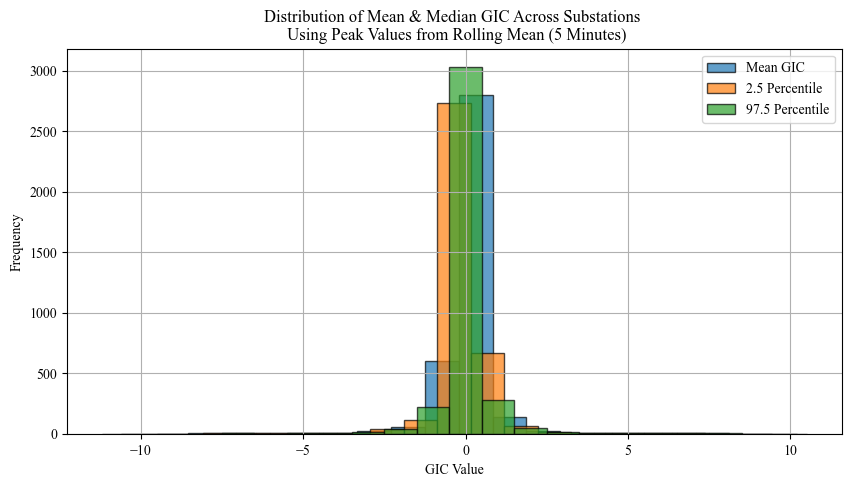

In [221]:
nerc_matching_sub, nerc_matching_monitors = get_unique_sites_substations(matches_df_nerc_sub, nerc=True)
gic_realtime = get_gic_measurements(nerc_matching_monitors, peak_times, ds_gic_nerc)

plt.figure(figsize=(10, 5))

# Histogram of mean GIC values
plt.hist(
    mean_values[:, 11], bins=20, alpha=0.7, label="Mean GIC", edgecolor="black"
)

# Histogram of median GIC values
plt.hist(
    uncertainty_arr[0, :, 11],
    bins=20,
    alpha=0.7,
    label="2.5 Percentile",
    edgecolor="black",
)

# Histogram of median GIC values
plt.hist(
    uncertainty_arr[1, :, 11],
    bins=20,
    alpha=0.7,
    label="97.5 Percentile",
    edgecolor="black",
)

plt.xlabel("GIC Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mean & Median GIC Across Substations \n Using Peak Values from Rolling Mean (5 Minutes)")
plt.legend()
plt.grid(True)
plt.show()

In [222]:
# Find close distances btween 3 datasets TVA, NERC and Simulated
threshold=30

# Primary data for comparison
trafo_unique = trafo_gic_gdf.drop_duplicates(subset="sub_id")
trafo_unique.reset_index(inplace=True)

ds_primary = trafo_unique.copy()
trafos = ds_primary.sub_id.values

# Secondary data for comparison
ds_other = ds_gic_nerc.copy()
site_ids_clean = [site for site in site_ids if site in ds_other.device.values]
ds_other = ds_other.sel(device=site_ids_clean)

prim_lat = ds_primary.latitude.values
prim_lon = ds_primary.longitude.values
other_lat = ds_other.latitude.values
other_lon = ds_other.longitude.values
other_monitors = ds_other.device.values

# Compute the pairwise distances
dists = haversine_dist(prim_lat[:, None], prim_lon[:, None],
                       other_lat[None, :], other_lon[None, :])
match_ids = []
match_dists = []
for row in dists:
    valid = np.where(row <= threshold)[0]
    if valid.size:
        match_ids.append(other_monitors[valid])
        match_dists.append(row[valid])
    else:
        match_ids.append(np.nan)
        match_dists.append(np.nan)

valid_ids = np.array([not is_nan_or_empty(s) for s in match_ids])
valid_dists = np.array(match_dists, dtype=object)[valid_ids]
valid_match_ids = np.array(match_ids, dtype=object)[valid_ids]
valid_substations = trafos[valid_ids]

In [223]:
def find_close_matches(trafo_gic_gdf, ds_gic_meas, site_ids=None, threshold=2, nerc=True):
    # Primary data: remove duplicate substations and reset index
    trafo_unique = trafo_gic_gdf.drop_duplicates(subset="sub_id").reset_index(drop=True)
    ds_primary = trafo_unique.copy()
    trafos = ds_primary.sub_id.values

    # Secondary data: filter devices based on site_ids
    ds_other = ds_gic_meas.copy()
    
    if nerc:
        site_ids_clean = [site for site in site_ids if site in ds_other.device.values]
        ds_other = ds_other.sel(device=site_ids_clean)

    prim_lat = ds_primary.latitude.values
    prim_lon = ds_primary.longitude.values
    other_lat = ds_other.latitude.values
    other_lon = ds_other.longitude.values
    other_monitors = ds_other.device.values

    # Compute pairwise distances
    dists = haversine_dist(prim_lat[:, None], prim_lon[:, None],
                           other_lat[None, :], other_lon[None, :])
    
    match_ids = []
    match_dists = []
    for row in dists:
        valid = np.where(row <= threshold)[0]
        if valid.size:
            match_ids.append(other_monitors[valid])
            match_dists.append(row[valid])
        else:
            match_ids.append(np.nan)
            match_dists.append(np.nan)

    valid_ids = np.array([not is_nan_or_empty(s) for s in match_ids])
    valid_dists = np.array(match_dists, dtype=object)[valid_ids]
    valid_match_ids = np.array(match_ids, dtype=object)[valid_ids]
    valid_substations = trafos[valid_ids]

    return valid_match_ids, valid_dists, valid_substations, valid_dists, trafo_unique


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.54it/s]


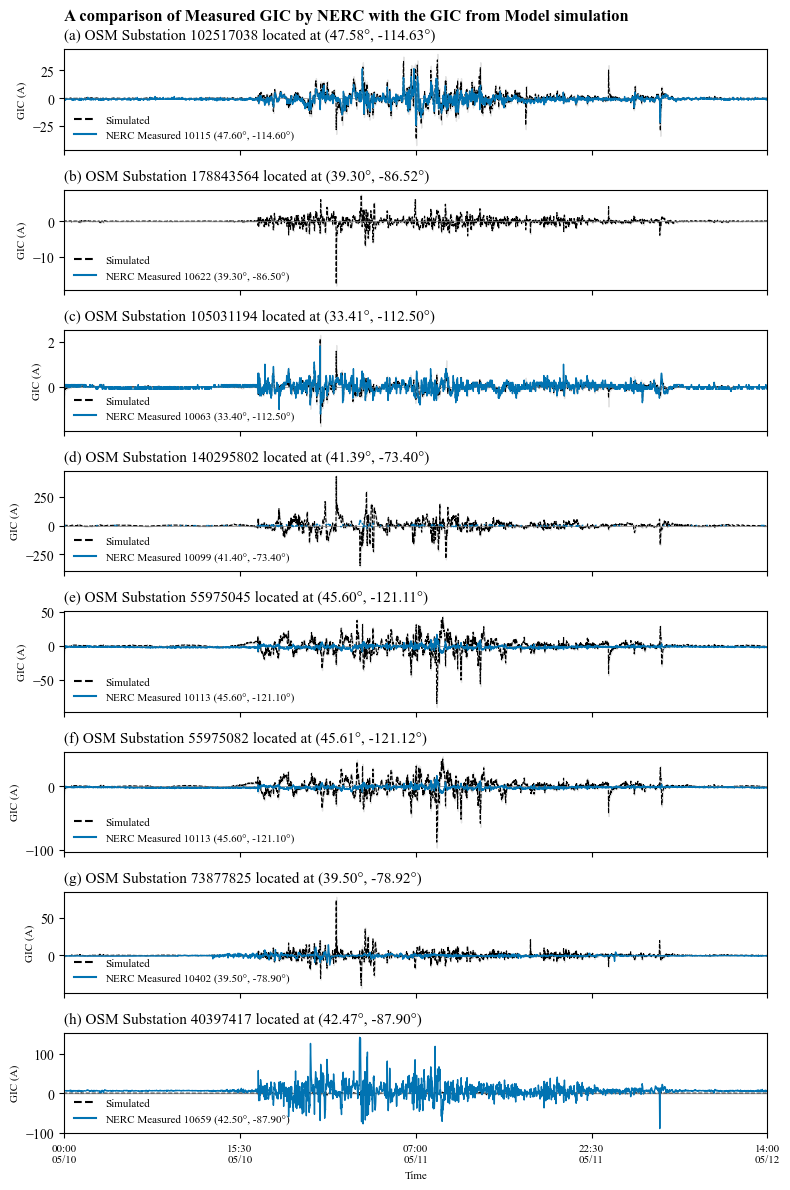

In [224]:
valid_match_ids, valid_dists, valid_substations, valid_dists, trafo_unique = find_close_matches(trafo_gic_gdf, ds_gic_nerc, site_ids=site_ids, threshold=3.5)

ds = ds_gic_nerc.copy()
substation_indices = [np.where(substation_names == sub)[0][0] 
                      for sub in substation_names if sub in valid_substations]
percentiles = uncertainty_arr.copy()

# Extract required statistics for the valid substations
mean_simulated   = mean_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]
lower_bound      = percentiles[0, substation_indices, 1:]
upper_bound      = percentiles[1, substation_indices, 1:]

# Get number of valid substations
n_valid_sub = len(valid_substations)

# Randomly select 7 sites (if fewer than 6, select all)
sub_to_choose = 8
if n_valid_sub >= sub_to_choose:
    selected_indices = np.random.choice(range(n_valid_sub), sub_to_choose, replace=False)
else:
    selected_indices = list(range(n_valid_sub))
    
n_selected = len(selected_indices)

# Create a single-column subplot with one row per selected site
fig, axes = plt.subplots(nrows=n_selected, ncols=1, figsize=(8, 12), sharex=True)
if n_selected == 1:
    axes = [axes]

# Dynamic color palette for measured data across selected sites
site_palette = sns.color_palette("colorblind", n_selected)

for j, idx in enumerate(tqdm(selected_indices)):
    current_ax = axes[j]
    
    # Get current close site information
    close_site_list = valid_match_ids[idx]
    mag_station_close = valid_substations[idx]
    sub_lat_close, sub_lon_close = trafo_unique[trafo_unique.sub_id == mag_station_close][['latitude', 'longitude']].values[0]
    
    # Plot simulated (median) GIC with uncertainty bounds for this substation (use index 'idx')
    current_ax.plot(peak_times, median_simulated[idx, :],
                    color='black', linestyle='--', linewidth=0.8)
    current_ax.fill_between(peak_times, lower_bound[idx, :], upper_bound[idx, :],
                            color='gray', alpha=0.2)
    current_ax.axhline(0.0, color="gray", linewidth=0.5)
    current_ax.set_ylabel("GIC (A)", fontsize=8)
    
    if j == 0:
        current_ax.text(0.0, 1.4, 
            "A comparison of Measured GIC by NERC with the GIC from Model simulation", 
            transform=current_ax.transAxes, ha='left', va='top', 
            fontweight="bold", fontsize=12)
            
    current_ax.text(0.0, 1.1, 
        f'({chr(97+j)}) OSM Substation {mag_station_close} located at ({sub_lat_close:.2f}°, {sub_lon_close:.2f}°)',
        transform=current_ax.transAxes, fontsize=11)

        
    # Plot measured data for each device in the current close site list
    measured_palette = sns.color_palette("colorblind", len(close_site_list))
    for i_cl, close_site in enumerate(close_site_list):
        current_ax.plot(peak_times, ds.gic.sel(device=close_site, time=peak_times),
                        color=measured_palette[i_cl], linewidth=1)
    
    # Build legend for measured devices
    lats = ds.latitude.sel(device=close_site_list).values
    lons = ds.longitude.sel(device=close_site_list).values
    line_legend_elements_close_sites = [
        Line2D([0, 0.3], [0, 0], linestyle="-", color=measured_palette[i_cl],
               label=f'NERC Measured {close_site} ({lats[i_cl]:.2f}°, {lons[i_cl]:.2f}°)')
        for i_cl, close_site in enumerate(close_site_list)
    ]
    line_legend_element_sim = [Line2D([0, 0.3], [0, 0], linestyle="--", color="black", label='Simulated')]
    
    legend_elements = line_legend_element_sim + line_legend_elements_close_sites
    current_ax.legend(handles=legend_elements, loc='lower left', ncol=1,
                      frameon=False, bbox_to_anchor=(0, -0.01), fontsize=8)
    
    # Format x-axis only for the bottom subplot
    if j == n_selected - 1:
        current_ax.set_xlim(peak_times[0], peak_times[-1])
        tick_positions = [peak_times[0],
                          peak_times[len(peak_times) // 4],
                          peak_times[len(peak_times) // 2],
                          peak_times[3 * len(peak_times) // 4],
                          peak_times[-1]]
        current_ax.set_xticks(tick_positions)
        current_ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M\n%m/%d") for t in tick_positions],
                                    fontsize=8)
        current_ax.set_xlabel("Time", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
fig.savefig(figures_dir / "gic_comparison_sim_nerc.png", dpi=300, bbox_inches="tight")
plt.show()

In [225]:
# matching_substations = nerc_matching_sub.copy()
# matching_sites = nerc_matching_monitors.copy()
# matches_df = matches_df_nerc_sub.copy()
# ds = ds_gic_nerc.copy()
# substation_indices = [np.where(substation_names == sub)[0][0] for sub in matching_substations if sub in substation_names]

# close_sites = [10114, 10115, 10063, 10250, 10077, 10622] # Sites with almost accurate depiction of GIC
# not_close_sites = [10659, 10113, 10402, 10052, 10076, 10099, 10255] # sites with almost not accurate depiction of GIC

# # Compute statistics (keep your existing statistics computation)
# # mean_values = np.mean(data_array, axis=0)
# # median_values = np.median(data_array, axis=0)
# percentiles = uncertainty_arr.copy()

# # Extract required statistics
# mean_simulated = mean_values[substation_indices, 1:]
# median_simulated = median_values[substation_indices, 1:]
# lower_bound = percentiles[0, substation_indices, 1:]
# upper_bound = percentiles[1, substation_indices, 1:]

# # legend elements
# legend_names = ["Measured GIC", "Median Simulated GIC"]
# legend_colors = ["darkred", "black"]
# line_weights = ["-", "--"]

# # Create a figure with two columns
# fig, axes = plt.subplots(nrows=max(len(close_sites), len(not_close_sites)), ncols=2, figsize=(8, 15), sharex=True)

# # Plot both columns (close sites first)
# for i, close_site in enumerate(tqdm(close_sites)):
    
#     site_idx_close = np.where(matching_sites == close_site)[0][0]
#     mag_station_close = matching_substations[site_idx_close]
#     sub_lat_close, sub_lon_close = matches_df[matches_df.substation == mag_station_close][['sub_lat', 'sub_lon']].values[0]
#     mag_lat_close = ds.latitude.sel(device=close_site).values
#     mag_lon_close = ds.longitude.sel(device=close_site).values

#     # Plot close sites (left column)
#     axes[i, 0].plot(peak_times, gic_realtime[site_idx_close, :], color='darkred', linewidth=1)
#     axes[i, 0].plot(peak_times, median_simulated[site_idx_close, :], color='black', linestyle='--', linewidth=0.8)
#     axes[i, 0].fill_between(peak_times, lower_bound[site_idx_close, :], upper_bound[site_idx_close, :], color='gray', alpha=0.2)
#     axes[i, 0].set_ylabel("GIC (A)", fontsize=8)
#     axes[i, 0].axhline(0.0, color="gray", linewidth=0.5)
    
#     # Add site information
#     axes[i, 0].text(0, 1.05, f'({chr(97 + (i) * 2)}) OSM Substation {mag_station_close} ({sub_lat_close:.2f}°, {sub_lon_close:.2f}°) and\nNERC GIC monitor {close_site} ({mag_lat_close:.2f}°, {mag_lon_close:.2f}°)', 
#                     transform=axes[i, 0].transAxes, fontsize=9)
    
#     # For the last row of close sites, set x-axis formatting
#     if i == len(close_sites) - 1:
#         axes[i, 0].set_xlim(peak_times[0], peak_times[-1])
#         tick_positions = [peak_times[0], peak_times[len(peak_times) // 4], 
#                           peak_times[len(peak_times) // 2], 
#                           peak_times[3 * len(peak_times) // 4], peak_times[-1]]
        
#         axes[i, 0].set_xticks(tick_positions)
#         axes[i, 0].set_xticklabels([pd.to_datetime(t).strftime("%H:%M\n%m/%d") for t in tick_positions],fontsize=8)
        
#         # X-axis label
#         axes[i, 0].set_xlabel("Time", fontsize=8)

# # Plot not close sites (right column)
# for i, not_close_site in enumerate(not_close_sites):
    
#     site_idx_not_close = np.where(matching_sites == not_close_site)[0][0]
#     mag_station_not_close = matching_substations[site_idx_not_close]
#     sub_lat_not_close, sub_lon_not_close = matches_df[matches_df.substation == mag_station_not_close][['sub_lat', 'sub_lon']].values[0]
#     mag_lat_not_close = ds.latitude.sel(device=not_close_site).values
#     mag_lon_not_close = ds.longitude.sel(device=not_close_site).values
    
#     # Plot not close sites (right column)
#     axes[i, 1].plot(peak_times, gic_realtime[site_idx_not_close, :], color='darkred', linewidth=1)
#     axes[i, 1].plot(peak_times, median_simulated[site_idx_not_close, :], color='black', linestyle='--', linewidth=0.8)
#     axes[i, 1].fill_between(peak_times, lower_bound[site_idx_not_close, :], upper_bound[site_idx_not_close, :], color='gray', alpha=0.2)
#     axes[i, 1].set_ylabel("GIC (A)", fontsize=8)
#     axes[i, 1].axhline(0.0, color="gray", linewidth=0.5)
    
#     # Add site information
#     axes[i, 1].text(0, 1.05, f'({chr(98 + (i) * 2)}) OSM Substation {mag_station_not_close} ({sub_lat_not_close:.2f}°, {sub_lon_not_close:.2f}°) and\nNERC GIC monitor {not_close_site} ({mag_lat_not_close:.2f}°, {mag_lon_not_close:.2f}°)', 
#                     transform=axes[i, 1].transAxes, fontsize=9)

#     # # For the last row of not close sites, set x-axis formatting
#     # if i == len(not_close_sites) - 1:
#     #     axes[i, 1].set_xlim(peak_times[0], peak_times[-1])
#     #     tick_positions = [peak_times[0], peak_times[len(peak_times) // 4], 
#     #                       peak_times[len(peak_times) // 2], 
#     #                       peak_times[3 * len(peak_times) // 4], peak_times[-1]]
        
#     #     axes[i, 1].set_xticks(tick_positions)
#     #     axes[i, 1].set_xticklabels([pd.to_datetime(t).strftime("%H:%M\n%m/%d") for t in tick_positions], fontsize=8)
        
#     #     # X-axis label
#     #     axes[i, 1].set_xlabel("Time", fontsize=8)

# # Legend elements
# patch_legend_element = [mpatches.Patch(color="gray", label=str('Uncertainty (95% CI)'))]

# # Create legend elements once
# line_legend_elements = [Line2D([0], [0], linestyle=line_weights[i], color=legend_colors[i], label=f'{label}') 
#                          for i, label in enumerate(legend_names)]

# legend_elements = line_legend_elements + patch_legend_element

# fig.legend(
#     handles=legend_elements, 
#     # title="Thresholds (A/Ph):", 
#     loc='lower center', 
#     ncol=len(legend_elements) + 1,  # +1 to include space for title
#     frameon=False, 
#     bbox_to_anchor=(0.5, -0.01),
#     alignment='left',  # Aligns title to the left
#     fontsize=8
# )

# # Add x tick labels at the bottom left and right plots
# ds = ds.resample(time='min').first()
# times = pd.to_datetime(ds.time.values)

# # Format x-axis labels on the bottom row only with date formatting
# tick_positions = np.linspace(0, len(times)-1, 6, dtype=int)
# tick_times = [times[i] for i in tick_positions]
# for ax in axes[-1, :]:
#     ax.set_xticks(tick_times)
#     ax.set_xticklabels([t.strftime("%H:%M\n%m/%d") for t in tick_times])
#     ax.set_xlabel("Time")

# # Adjust layout
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.22, hspace=0.4)

# fig.savefig("dennies_figs/gic_comparison_peak.png", dpi=300)
# plt.show()

In [226]:
tva_gic_files = list(tva_gic_meas_path.glob("*.csv"))

In [227]:
tva_name_map = {
    "anderson": None,
    "montgomery": "Montgomery",
    "widowscreek2": "Widows Creek 2",
    "gleason": "Gleason",
    "raccoonmountain": "Raccoon Mountain",
    # "paradise2" is skipped
    "johnsonville": "Johnsonville",
    "pinhook": "Pinhook",
    "paradise3": "Paradise",
    "southaven": "Southaven",
    "shelby": "Shelby",
    "eastpoint": "East Point",
    "bullrun": "Bull Run",
    "sullivan": "Sullivan",
    "weakley": "Weakley",
    "union": "Union",
    "rutherford": "Rutherford",
    "bradley": "Bradley"
}

device_data = {}
timestamps_set = set()

for tva_gic_path_file in tva_gic_files:
    file_stem = (tva_gic_path_file.stem).split("_")[0].split("-")[1]

    name = tva_name_map.get(file_stem, None)

    if name == None:
        continue
        
    df = pd.read_csv(tva_gic_path_file, names=["SampleDateTime", "GICMeasured"])
    df["GICDeviceID"] = name
    df["SampleDateTime"] = pd.to_datetime(
        df["SampleDateTime"], errors="coerce"
    )

    for device_id, group in df.groupby("GICDeviceID"):
        if device_id not in device_data:
            device_data[device_id] = {}

        timestamps_set.update(group["SampleDateTime"])
        device_data[device_id].update(
            dict(zip(group["SampleDateTime"], group["GICMeasured"]))
        )

# Step 2: Create a uniform time index
timestamps = sorted(timestamps_set)

# Step 3: Convert data to a 2D array (time x device), filling missing values with NaN
device_ids = sorted(device_data.keys())
data_array = np.full((len(timestamps), len(device_ids)), np.nan)

for j, device_id in enumerate(device_ids):
    for i, timestamp in enumerate(timestamps):
        if timestamp in device_data[device_id]:
            data_array[i, j] = device_data[device_id][timestamp]

# Step 4: Create an Xarray Dataset
ds_gic_tva = xr.Dataset(
    data_vars={"gic": (["time", "device"], data_array)},
    coords={"time": timestamps, "device": device_ids},
)

metadata_cols = [
    "latitude",
    "longitude",
    "type",
]

In [228]:
gic_monitors_dict = tva_gic_meas_metadat.set_index("device").to_dict()

for col in metadata_cols:
    ds_gic_tva = ds_gic_tva.assign_coords(
        {
            col.lower().replace(" ", "_"): (
                "device",
                [gic_monitors_dict[col].get(d, np.nan) for d in device_ids],
            )
        }
    )

# Save the xarray dataset to a NetCDF file
ds_gic_tva.to_netcdf(data_loc / "tva_gic.nc")

In [229]:
tva_matching_sub, tva_matching_monitors = get_unique_sites_substations(matches_df_tva_sub, nerc=False)

gic_realtime = get_gic_measurements(tva_matching_monitors, peak_times, ds_gic_tva)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3721/3721 [00:06<00:00, 532.48it/s]


In [230]:
# matching_substations = tva_matching_sub.copy()
# matching_sites = tva_matching_monitors.copy()
# matches_df = matches_df_tva_sub.copy()
# ds = ds_gic_tva.copy()
# substation_indices = [np.where(substation_names == sub)[0][0] for sub in matching_substations if sub in substation_names]

# close_sites = ['Raccoon Mountain','Southaven',
#        'Shelby', 'Union', 'Gleason', 'Bull Run',]
# not_close_sites = ['Sullivan', 'Paradise', 'Weakley',
#        'Montgomery', 'Pinhook']

# # Compute statistics (keep your existing statistics computation)
# percentiles = uncertainty_arr.copy()

# # Extract required statistics
# mean_simulated = mean_values[substation_indices, 1:]
# median_simulated = median_values[substation_indices, 1:]
# lower_bound = percentiles[0, substation_indices, 1:]
# upper_bound = percentiles[1, substation_indices, 1:]

# # legend elements
# legend_names = ["Measured GIC", "Median Simulated GIC"]
# legend_colors = ["darkred", "black"]
# line_weights = ["-", "--"]

# # Create a figure with two columns
# fig, axes = plt.subplots(nrows=max(len(close_sites), len(not_close_sites)), ncols=2, figsize=(9, 12), sharex=True)

# # Plot both columns (close sites first)
# for i, close_site in enumerate(close_sites):
    
#     site_idx_close = np.where(matching_sites == close_site)[0][0]
#     mag_station_close = matching_substations[site_idx_close]
#     sub_lat_close, sub_lon_close = matches_df[matches_df.substation == mag_station_close][['sub_lat', 'sub_lon']].values[0]
#     mag_lat_close = ds.latitude.sel(device=close_site).values
#     mag_lon_close = ds.longitude.sel(device=close_site).values

#     # Plot close sites (left column)
#     axes[i, 0].plot(peak_times, gic_realtime[site_idx_close, :], color='darkred', linewidth=1)
#     axes[i, 0].plot(peak_times, median_simulated[site_idx_close, :], color='black', linestyle='--', linewidth=0.8)
#     axes[i, 0].fill_between(peak_times, lower_bound[site_idx_close, :], upper_bound[site_idx_close, :], color='gray', alpha=0.2)
#     axes[i, 0].set_ylabel("GIC (A)", fontsize=8)
#     axes[i, 0].axhline(0.0, color="gray", linewidth=0.5)
    
#     # Add site information
#     axes[i, 0].text(0, 1.05, f'({chr(97 + (i) * 2)}) OSM Substation {mag_station_close} ({sub_lat_close:.2f}°, {sub_lon_close:.2f}°) and\nTVA GIC monitor {close_site} ({mag_lat_close:.2f}°, {mag_lon_close:.2f}°)', 
#                     transform=axes[i, 0].transAxes, fontsize=9)
    
#     # For the last row of close sites, set x-axis formatting
#     if i == len(close_sites) - 1:
#         axes[i, 0].set_xlim(peak_times[0], peak_times[-1])
#         tick_positions = [peak_times[0], peak_times[len(peak_times) // 4], 
#                           peak_times[len(peak_times) // 2], 
#                           peak_times[3 * len(peak_times) // 4], peak_times[-1]]
        
#         axes[i, 0].set_xticks(tick_positions)
#         axes[i, 0].set_xticklabels([pd.to_datetime(t).strftime("%H:%M\n%m/%d") for t in tick_positions],fontsize=8)
        
#         # X-axis label
#         axes[i, 0].set_xlabel("Time", fontsize=8)

# # Plot not close sites (right column)
# for i, not_close_site in enumerate(not_close_sites):
    
#     site_idx_not_close = np.where(matching_sites == not_close_site)[0][0]
#     mag_station_not_close = matching_substations[site_idx_not_close]
#     sub_lat_not_close, sub_lon_not_close = matches_df[matches_df.substation == mag_station_not_close][['sub_lat', 'sub_lon']].values[0]
#     mag_lat_not_close = ds.latitude.sel(device=not_close_site).values
#     mag_lon_not_close = ds.longitude.sel(device=not_close_site).values
    
#     # Plot not close sites (right column)
#     axes[i, 1].plot(peak_times, gic_realtime[site_idx_not_close, :], color='darkred', linewidth=1)
#     axes[i, 1].plot(peak_times, median_simulated[site_idx_not_close, :], color='black', linestyle='--', linewidth=0.8)
#     axes[i, 1].fill_between(peak_times, lower_bound[site_idx_not_close, :], upper_bound[site_idx_not_close, :], color='gray', alpha=0.2)
#     axes[i, 1].set_ylabel("GIC (A)", fontsize=8)
#     axes[i, 1].axhline(0.0, color="gray", linewidth=0.5)
    
#     # Add site information
#     axes[i, 1].text(0, 1.05, f'({chr(98 + (i) * 2)}) OSM Substation {mag_station_not_close} ({sub_lat_not_close:.2f}°, {sub_lon_not_close:.2f}°) and\nNERC GIC monitor {not_close_site} ({mag_lat_not_close:.2f}°, {mag_lon_not_close:.2f}°)', 
#                     transform=axes[i, 1].transAxes, fontsize=9)

# # Legend elements
# patch_legend_element = [mpatches.Patch(color="gray", label=str('Uncertainty (95% CI)'))]

# # Create legend elements once
# line_legend_elements = [Line2D([0], [0], linestyle=line_weights[i], color=legend_colors[i], label=f'{label}') 
#                          for i, label in enumerate(legend_names)]

# legend_elements = line_legend_elements + patch_legend_element

# fig.legend(
#     handles=legend_elements, 
#     # title="Thresholds (A/Ph):", 
#     loc='lower center', 
#     ncol=len(legend_elements) + 1,  # +1 to include space for title
#     frameon=False, 
#     bbox_to_anchor=(0.5, -0.01),
#     alignment='left',  # Aligns title to the left
#     fontsize=8
# )

# # Add x tick labels at the bottom left and right plots
# ds = ds.resample(time='min').first()
# times = pd.to_datetime(ds.time.values)

# # Format x-axis labels on the bottom row only with date formatting
# tick_positions = np.linspace(0, len(times)-1, 6, dtype=int)
# tick_times = [times[i] for i in tick_positions]
# for ax in axes[-1, :]:
#     ax.set_xticks(tick_times)
#     ax.set_xticklabels([t.strftime("%H:%M\n%m/%d") for t in tick_times])
#     ax.set_xlabel("Time")

# # Adjust layout
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.22, hspace=0.3)

# fig.savefig("dennies_figs/gic_comparison_tva.png", dpi=300)
# plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 261.66it/s]


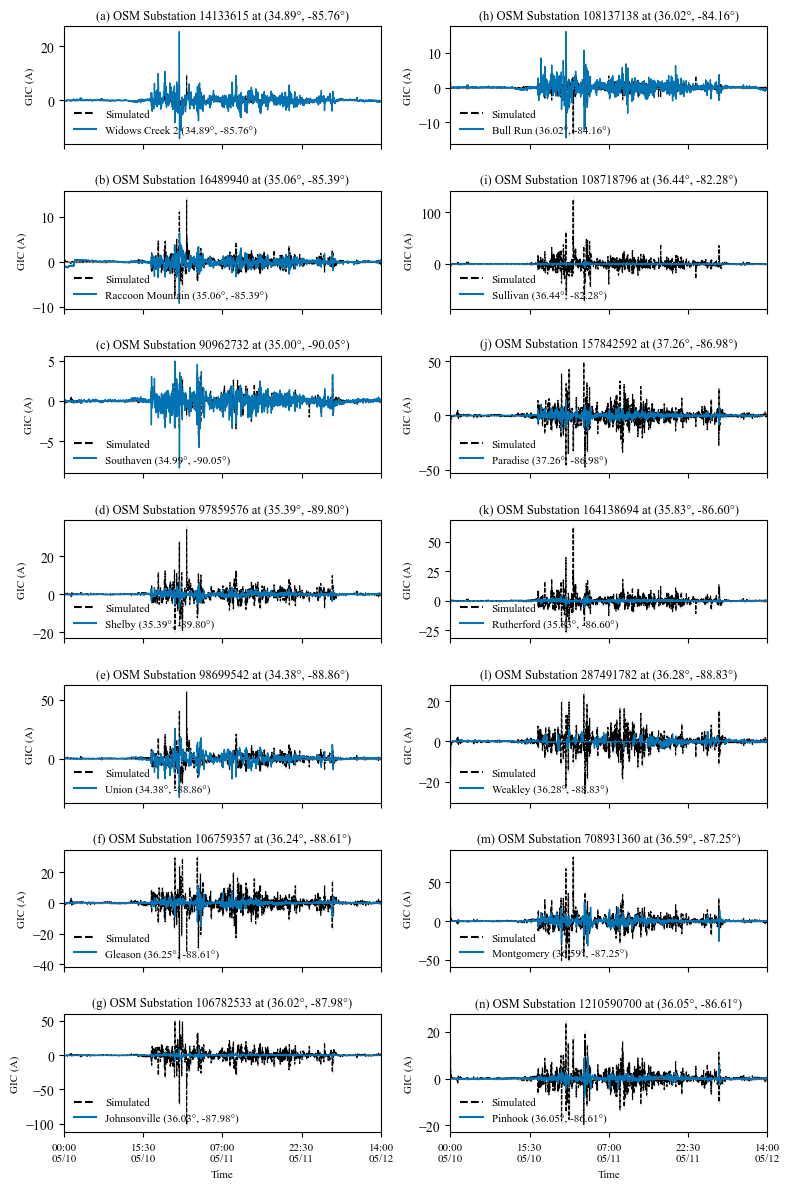

In [231]:
valid_match_ids, valid_dists, valid_substations, valid_dists, trafo_unique = find_close_matches(trafo_gic_gdf, ds_gic_tva, site_ids, nerc=False)

ds = ds_gic_tva.copy()
substation_indices = [np.where(substation_names == sub)[0][0] for sub in substation_names if sub in valid_substations]
percentiles = uncertainty_arr.copy()

# Extract required statistics
mean_simulated = mean_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]
lower_bound = percentiles[0, substation_indices, 1:]
upper_bound = percentiles[1, substation_indices, 1:]

# Dynamic legend and color palette setup
legend_names = ["Measured GIC", "Median Simulated GIC"]
site_palette = sns.color_palette("colorblind", len(valid_substations))
n_valid_sub = len(valid_substations)

if n_valid_sub > 5:
    nrows = n_valid_sub // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(8, 12), sharex=True)
    total_subplots = nrows * 2
else:
    nrows = n_valid_sub
    fig, axes = plt.subplots(nrows=n_valid_sub, ncols=1, figsize=(8, 8), sharex=True)
    total_subplots = n_valid_sub
    
for i, close_site_list in enumerate(tqdm(valid_match_ids[0:total_subplots])):
    # Select current axis (handle 1D or 2D array of axes)
    current_ax = axes[i] if n_valid_sub <= 5 else axes[i % nrows, i // nrows]

    mag_station_close = valid_substations[i]
    sub_lat_close, sub_lon_close = trafo_unique[trafo_unique.sub_id == mag_station_close][['latitude', 'longitude']].values[0]

    # Plot median simulated line with label
    current_ax.plot(peak_times, median_simulated[i, :],
                    color='black', linestyle='--', linewidth=0.8)
    # Plot uncertainty bounds
    current_ax.fill_between(peak_times, lower_bound[i, :], upper_bound[i, :],
                            color='gray', alpha=0.2)
    current_ax.set_ylabel("GIC (A)", fontsize=8)
    current_ax.axhline(0.0, color="gray", linewidth=0.5)

    # Add site information
    current_ax.set_title(f'({chr(97 + i)}) OSM Substation {mag_station_close} at ({sub_lat_close:.2f}°, {sub_lon_close:.2f}°)', fontsize=9)

    # Plot measured data for close sites with dynamic color palette
    measured_palette = sns.color_palette("colorblind", len(close_site_list))
    
    for i_cl, close_site in enumerate(close_site_list):
        current_ax.plot(peak_times, ds.gic.sel(device=close_site, time=peak_times),
                        color=measured_palette[i_cl], linewidth=1)

    # Design a legend
    # patch_legend_element = [mpatches.Patch(color="gray", label=str('Uncertainty (95% CI)'))]

    # Create legend elements once
    lats = ds.latitude.sel(device=close_site_list).values
    lons = ds.longitude.sel(device=close_site_list).values
    line_legend_elements_close_sites = [Line2D([0], [0], linestyle="-", color=measured_palette[i], label=f'{close_site_list[i]} ({lats[i]:.2f}°, {lons[i]:.2f}°)') 
                             for i, label in enumerate(close_site_list)]

    line_legend_element_sim = [Line2D([0], [0], linestyle="--", color="black", label=f'Simulated')]
    
    legend_elements = line_legend_element_sim + line_legend_elements_close_sites # + patch_legend_element
    
    current_ax.legend(
        handles=legend_elements, 
        loc='lower left', 
        ncol=1,  # +1 to include space for title
        frameon=False, 
        bbox_to_anchor=(0, -0.01),
        alignment='left',  # Aligns title to the left
        fontsize=8
    )
    
    # Add x-axis formatting for the bottom row subplots
    if (n_valid_sub > 5 and (i % nrows == nrows - 1)) or (n_valid_sub <= 5 and i == n_valid_sub - 1):
        current_ax.set_xlim(peak_times[0], peak_times[-1])
        tick_positions = [peak_times[0],
                          peak_times[len(peak_times) // 4],
                          peak_times[len(peak_times) // 2],
                          peak_times[3 * len(peak_times) // 4],
                          peak_times[-1]]
        current_ax.set_xticks(tick_positions)
        current_ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M\n%m/%d") for t in tick_positions],
                                    fontsize=8)
        current_ax.set_xlabel("Time", fontsize=8)
    

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.22, hspace=0.4)

fig.savefig(figures_dir / "gic_comparison_tva.png", dpi=300)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 256.71it/s]


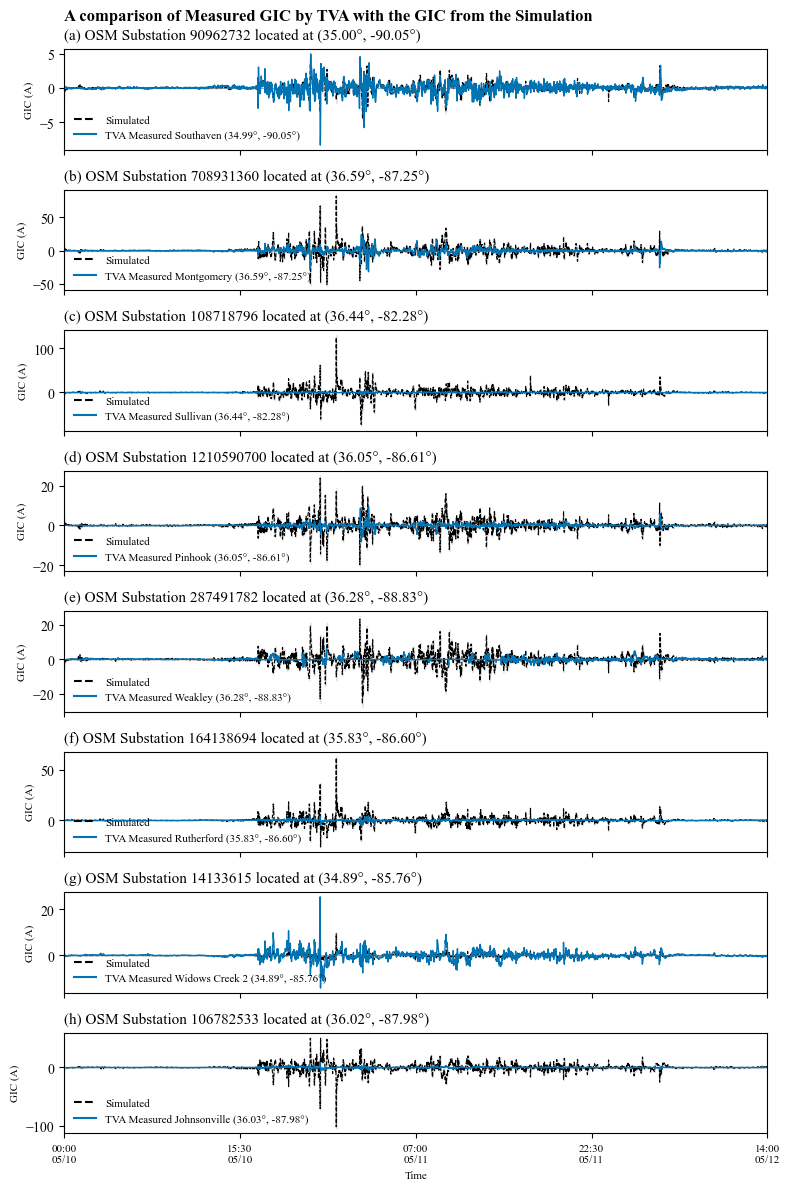

In [232]:
valid_match_ids, valid_dists, valid_substations, valid_dists, trafo_unique = find_close_matches(trafo_gic_gdf, ds_gic_tva, site_ids, nerc=False)

ds = ds_gic_tva.copy()
substation_indices = [np.where(substation_names == sub)[0][0] 
                      for sub in substation_names if sub in valid_substations]
percentiles = uncertainty_arr.copy()

# Extract required statistics for the valid substations
mean_simulated   = mean_values[substation_indices, 1:]
median_simulated = median_values[substation_indices, 1:]
lower_bound      = percentiles[0, substation_indices, 1:]
upper_bound      = percentiles[1, substation_indices, 1:]

# Get number of valid substations
n_valid_sub = len(valid_substations)

# Randomly select 7 sites (if fewer than 6, select all)
sub_to_choose = 8
if n_valid_sub >= sub_to_choose:
    selected_indices = np.random.choice(range(n_valid_sub), sub_to_choose, replace=False)
else:
    selected_indices = list(range(n_valid_sub))
    
n_selected = len(selected_indices)

# Create a single-column subplot with one row per selected site
fig, axes = plt.subplots(nrows=n_selected, ncols=1, figsize=(8, 12), sharex=True)
if n_selected == 1:
    axes = [axes]

# Dynamic color palette for measured data across selected sites
site_palette = sns.color_palette("colorblind", n_selected)

for j, idx in enumerate(tqdm(selected_indices)):
    current_ax = axes[j]
    
    # Get current close site information
    close_site_list = valid_match_ids[idx]
    mag_station_close = valid_substations[idx]
    sub_lat_close, sub_lon_close = trafo_unique[trafo_unique.sub_id == mag_station_close][['latitude', 'longitude']].values[0]
    
    # Plot simulated (median) GIC with uncertainty bounds for this substation (use index 'idx')
    current_ax.plot(peak_times, median_simulated[idx, :],
                    color='black', linestyle='--', linewidth=0.8)
    current_ax.fill_between(peak_times, lower_bound[idx, :], upper_bound[idx, :],
                            color='gray', alpha=0.2)
    current_ax.axhline(0.0, color="gray", linewidth=0.5)
    current_ax.set_ylabel("GIC (A)", fontsize=8)
    
    if j == 0:
        current_ax.text(0.0, 1.4, 
            "A comparison of Measured GIC by TVA with the GIC from the Simulation", 
            transform=current_ax.transAxes, ha='left', va='top', 
            fontweight="bold", fontsize=12)
            
    current_ax.text(0.0, 1.1, 
        f'({chr(97+j)}) OSM Substation {mag_station_close} located at ({sub_lat_close:.2f}°, {sub_lon_close:.2f}°)',
        transform=current_ax.transAxes, fontsize=11)

        
    # Plot measured data for each device in the current close site list
    measured_palette = sns.color_palette("colorblind", len(close_site_list))
    for i_cl, close_site in enumerate(close_site_list):
        current_ax.plot(peak_times, ds.gic.sel(device=close_site, time=peak_times),
                        color=measured_palette[i_cl], linewidth=1)
    
    # Build legend for measured devices
    lats = ds.latitude.sel(device=close_site_list).values
    lons = ds.longitude.sel(device=close_site_list).values
    line_legend_elements_close_sites = [
        Line2D([0, 0.3], [0, 0], linestyle="-", color=measured_palette[i_cl],
               label=f'TVA Measured {close_site} ({lats[i_cl]:.2f}°, {lons[i_cl]:.2f}°)')
        for i_cl, close_site in enumerate(close_site_list)
    ]
    line_legend_element_sim = [Line2D([0, 0.3], [0, 0], linestyle="--", color="black", label='Simulated')]
    
    legend_elements = line_legend_element_sim + line_legend_elements_close_sites
    current_ax.legend(handles=legend_elements, loc='lower left', ncol=1,
                      frameon=False, bbox_to_anchor=(0, -0.01), fontsize=8)
    
    # Format x-axis only for the bottom subplot
    if j == n_selected - 1:
        current_ax.set_xlim(peak_times[0], peak_times[-1])
        tick_positions = [peak_times[0],
                          peak_times[len(peak_times) // 4],
                          peak_times[len(peak_times) // 2],
                          peak_times[3 * len(peak_times) // 4],
                          peak_times[-1]]
        current_ax.set_xticks(tick_positions)
        current_ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M\n%m/%d") for t in tick_positions],
                                    fontsize=8)
        current_ax.set_xlabel("Time", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
fig.savefig(figures_dir / "gic_comparison_tva.png", dpi=300, bbox_inches="tight")
plt.show()

In [233]:
def save_gic_comparison_csv(ds, trafo_unique, substation_names, valid_substations,
                            valid_match_ids, valid_dists, peak_times, uncertainty_arr,
                            mean_values, median_values, data_loc, output_folder="tva",
                            total_subplots=None):

    # Create output directory
    save_loc = data_loc / "dbor" / "gic-comparison" / output_folder
    os.makedirs(save_loc, exist_ok=True)

    # Compute indices for valid substations from substation_names
    substation_indices = [
        np.where(substation_names == sub)[0][0] 
        for sub in valid_substations if sub in substation_names
    ]

    # Copy uncertainty array and extract required statistics (skip first column)
    percentiles = uncertainty_arr.copy()
    mean_simulated   = mean_values[substation_indices, 1:]
    median_simulated = median_values[substation_indices, 1:]
    lower_bound      = percentiles[0, substation_indices, 1:]
    upper_bound      = percentiles[1, substation_indices, 1:]

    # Loop over each valid substation (up to total_subplots)
    for i, close_site_list in enumerate(valid_match_ids[:total_subplots]):
        dists = valid_dists[i]
        mag_station_close = valid_substations[i]
        sub_info = trafo_unique[trafo_unique.sub_id == mag_station_close][['latitude', 'longitude']]
        if sub_info.empty:
            continue
        sub_lat_close, sub_lon_close = sub_info.values[0]
        median_gic = median_simulated[i, :]
        lower_bound_gic, upper_bound_gic = lower_bound[i, :], upper_bound[i, :]

        site_dict = {
            "timestamp": peak_times,  # Time data
            "substation": [mag_station_close] * len(peak_times),
            "Sim GIC (Median)": median_gic,
            "Sim GIC (2.5)": lower_bound_gic,
            "Sim GIC (97.5)": upper_bound_gic,
            "sub lat": [sub_lat_close] * len(peak_times),
            "sub lon": [sub_lon_close] * len(peak_times)
        }

        # Add measured GIC data for each nearby site
        for i_cl, close_site in enumerate(close_site_list):
            lat = ds.latitude.sel(device=close_site).values
            lon = ds.longitude.sel(device=close_site).values
            gic = ds.gic.sel(device=close_site, time=peak_times).values
            dist = dists[i_cl]
            site_dict.update({
                f"site_{i_cl+1}_device": [close_site] * len(peak_times),
                f"site_{i_cl+1}_gic": gic,
                f"site_{i_cl+1}_Latitude": [lat] * len(peak_times),
                f"site_{i_cl+1}_Longitude": [lon] * len(peak_times),
                f"site_{i_cl+1}_Distance": [dist] * len(peak_times)
            })

        # Convert dictionary to DataFrame and save as CSV
        df = pd.DataFrame(site_dict)
        output_file = save_loc / f"site_{mag_station_close}.csv"
        df.to_csv(output_file, index=False)

In [234]:
# TVA
# Save the datasets
valid_match_ids, valid_dists, valid_substations, valid_dists, trafo_unique = find_close_matches(trafo_gic_gdf, ds_gic_tva, site_ids, nerc=False)
save_gic_comparison_csv(ds_gic_tva, trafo_unique, substation_names, valid_substations,
                            valid_match_ids, valid_dists, peak_times, uncertainty_arr,
                            mean_values, median_values, data_loc, output_folder="tva")

# NERC
valid_match_ids, valid_dists, valid_substations, valid_dists, trafo_unique = find_close_matches(trafo_gic_gdf, ds_gic_nerc, site_ids, nerc=True, threshold=10)
save_gic_comparison_csv(ds_gic_nerc, trafo_unique, substation_names, valid_substations,
                            valid_match_ids, valid_dists, peak_times, uncertainty_arr,
                            mean_values, median_values, data_loc, output_folder="nerc")

In [235]:
def compare_correlations(gic_meas, gic_sim):
    # Remove mean
    x = gic_meas - np.mean(gic_meas)
    y = gic_sim - np.mean(gic_sim)
    
    # Auto-correlation of measured
    auto_x = np.correlate(x, x, mode='full')
    lags_x = np.arange(-len(x)+1, len(x))
    
    # Auto-correlation of simulated
    auto_y = np.correlate(y, y, mode='full')
    lags_y = np.arange(-len(y)+1, len(y))
    
    # Cross-correlation
    cross_xy = np.correlate(x, y, mode='full')
    lags_xy = np.arange(-len(x)+1, len(x))
    
    return lags_xy, cross_xy, auto_x, lags_x, auto_y, lags_y

def compare_fft(gic_meas, gic_sim, fs=1/60):
    N = len(gic_meas)
    yf_meas = fft(gic_meas)
    yf_sim  = fft(gic_sim)
    xf = fftfreq(N, 1/fs)[:N//2]  # Frequency bins
    
    # Corrected variable name
    amps_meas = 2.0/N * np.abs(yf_meas[:N//2])
    amps_sim = 2.0/N * np.abs(yf_sim[:N//2])

    return xf, amps_meas, amps_sim

In [236]:
# # Sample 3 close and 3 not-close sites
# sampled_close_sites = close_sites[:3]
# sampled_not_close_sites = not_close_sites[:3]
# sampled_sites = sampled_close_sites + sampled_not_close_sites

# # Define colors and styles
# legend_names = ["Measured GIC", "Simulated GIC"]
# legend_colors = ["darkred", "black"]
# line_weights = ["-", "--"]

# # Create figure
# fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 12), sharex=False)

# # Iterate over sampled sites
# for i, device in enumerate(sampled_sites):
#     idx = list(matching_sites).index(device)
    
#     gic_meas = gic_realtime[idx, :]
#     gic_sim = median_simulated[idx, :]

#     # Compute FFT and correlations
#     xf, amps_meas, amps_sim = compare_fft(gic_meas, gic_sim)
#     lags_xy, cross_xy, auto_x, lags_x, auto_y, lags_y = compare_correlations(gic_meas, gic_sim)

#     # Normalize lags (assuming similar dimensions)
#     uniform_lags = np.arange(-len(gic_meas) + 1, len(gic_meas))

#     # Determine column (0 for left, 1 for right)
#     col = 0  # Always left for power spectrum
#     row = i  # Corresponding row

#     # Get location details
#     mag_station = matching_substations[idx]
#     sub_lat, sub_lon = matches_df[matches_df.substation == mag_station][['sub_lat', 'sub_lon']].values[0]
#     mag_lat = ds.latitude.sel(device=device).values
#     mag_lon = ds.longitude.sel(device=device).values

#     # Left Column: Power Spectrum
#     ax_left = axes[row, col]
#     ax_left.plot(xf, amps_meas, label="Measured", color="darkred", linewidth=1)
#     ax_left.plot(xf, amps_sim, label="Simulated", color="black", linestyle="--", linewidth=0.8)
#     ax_left.set_ylabel("Amplitude", fontsize=8)
#     ax_left.axhline(0.0, color="gray", linewidth=0.5)
#     ax_left.set_title(f"({chr(97 + row * 2)}) {device} - Power Spectrum", fontsize=9)

#     # Right Column: Auto & Cross-Correlation
#     ax_right = axes[row, 1]  # Right column for correlation
#     ax_right.plot(uniform_lags, auto_x, label="Auto-Corr (Measured)", color="darkred")
#     ax_right.plot(uniform_lags, auto_y, label="Auto-Corr (Simulated)", color="black", linestyle="--")
#     ax_right.plot(uniform_lags, cross_xy, label="Cross-Corr", color="blue")
#     ax_right.set_ylabel("Correlation", fontsize=8)
#     ax_right.axhline(0.0, color="gray", linewidth=0.5)
#     ax_right.set_title(f"({chr(97 + row * 2 + 1)}) {device} - Correlation", fontsize=9)

#     # # Annotate site information below each plot
#     # ax_right.text(0, -0.35, 
#     #     f"OSM Substation {mag_station} ({sub_lat:.2f}°, {sub_lon:.2f}°) & \nTVA GIC Monitor {device} ({mag_lat:.2f}°, {mag_lon:.2f}°)", 
#     #     transform=ax_right.transAxes, fontsize=8, va="top")

# # Create legend
# legend_elements = [
#     Line2D([0], [0], linestyle=line_weights[i], color=legend_colors[i], label=legend_names[i]) 
#     for i in range(len(legend_names))
# ] + [Patch(color="gray", alpha=0.2, label="Uncertainty (95% CI)")]

# fig.legend(handles=legend_elements, loc="lower center", ncol=len(legend_elements) + 1, frameon=False, fontsize=8)

# # Adjust layout
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.3, hspace=0.4)

# # Save figure
# fig.savefig("dennies_figs/spectral_analysis_tva.png", dpi=300)
# plt.show()

# Coherence


In [237]:
from scipy.signal import welch, coherence
from scipy import integrate

def compute_coherence_and_psd(gic_meas, gic_sim, fs=1/60, nperseg=256, noverlap=128, window='hann'):
    """
    Compute coherence and Welch PSD for two signals.
    
    Parameters:
      gic_meas (array): Measured signal.
      gic_sim (array): Simulated signal.
      fs (float): Sampling frequency.
      nperseg (int): Length of each segment.
      noverlap (int): Number of points to overlap.
      window (str): Desired window to use.
      
    Returns:
      f_coh, Cxy, f_welch, S_meas, S_sim
    """
    f_coh, Cxy = coherence(gic_meas, gic_sim, fs=fs, nperseg=nperseg, noverlap=noverlap, window=window)
    f_welch, S_meas = welch(gic_meas, fs=fs, nperseg=nperseg, noverlap=noverlap, window=window)
    _, S_sim = welch(gic_sim, fs=fs, nperseg=nperseg, noverlap=noverlap, window=window)
    return f_coh, Cxy, f_welch, S_meas, S_sim

def plot_coherence_and_psd(ds, trafo_unique, substation_names, valid_substations,
                           valid_match_ids, peak_times, uncertainty_arr,
                           mean_values, median_values, fig_name, fs=1/60, nperseg=256, 
                           noverlap=128, window='hann', nerc=True):
    if nerc:
        operator = "NERC"
    else:
        operator = "TVA"
        
    # Get indices for valid substations
    substation_indices = [np.where(substation_names == sub)[0][0] 
                          for sub in substation_names if sub in valid_substations]

    # Extract simulated signals (skip first column)
    mean_simulated   = mean_values[substation_indices, 1:]
    median_simulated = median_values[substation_indices, 1:]
    lower_bound      = uncertainty_arr[0, substation_indices, 1:]
    upper_bound      = uncertainty_arr[1, substation_indices, 1:]
    
    # Limit to maximum 6 rows (substations)
    n_valid_sub = len(valid_substations)
    nrows = min(8, n_valid_sub)
    total_subplots = nrows

    # Create figure with 2 columns (left: coherence, right: PSD)
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(9, 12), sharex='col')
    if nrows == 1:
        axes = np.array([axes])
        
    # Add supertitles (first axis of each column)
    axes[0, 0].text(0.47, 1.25, f"Coherence of Measured GIC by {operator} and Modeled GIC", 
                    transform=axes[0, 0].transAxes, ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    axes[0, 1].text(0.5, 1.25, f"Power Spectral Density (PSD) of measured and simulated GIC", 
                    transform=axes[0, 1].transAxes, ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    # Loop over substations to plot coherence and PSD
    for i, close_site_list in enumerate(tqdm(valid_match_ids[:total_subplots])):
        ax_coh = axes[i, 0]
        ax_psd = axes[i, 1]
        
        # Get substation info (using index i)
        mag_station_close = valid_substations[i]
        sub_info = trafo_unique[trafo_unique.sub_id == mag_station_close][['latitude', 'longitude']]
        if sub_info.empty:
            continue
        sub_lat_close, sub_lon_close = sub_info.values[0]
        # Use the first device in the list for the subtitle in coherence
        device_id = close_site_list[0]

        device_lat = ds.latitude.sel(device=device_id).values
        device_lon = ds.longitude.sel(device=device_id).values
        
        # Add subtitles (second text) on each subplot
        ax_coh.text(0.0, 1.1, 
                    f'({chr(97+i)}) OSM Substation {mag_station_close} against GIC Device {device_id}', 
                    transform=ax_coh.transAxes, fontsize=9)
        ax_psd.text(0.0, 1.1, 
                    f'({chr(97+i)}) OSM Substation {mag_station_close} against GIC Device {device_id} ', 
                    transform=ax_psd.transAxes, fontsize=9)
                    
        # Dynamic color palette for measured devices
        measured_palette = sns.color_palette("colorblind", len(close_site_list))
        
        # Loop over each device in the close site list
        for i_cl, close_site in enumerate(close_site_list):
            # Retrieve signals: measured for this site, simulated from median signal
            gic_meas = ds.gic.sel(device=close_site, time=peak_times).values
            gic_sim  = median_simulated[i, :]
            f_coh, Cxy, f_welch, S_meas, S_sim = compute_coherence_and_psd(gic_meas, gic_sim,
                                                                            fs=fs, nperseg=nperseg,
                                                                            noverlap=noverlap, window=window)
            ax_coh.plot(f_coh, Cxy, color=measured_palette[i_cl], linewidth=0.8)

            # Compute integrated power for each PSD
            int_S_meas = integrate.trapezoid(S_meas, f_welch)
            int_S_sim  = integrate.trapezoid(S_sim, f_welch)
            scale_factor = int_S_sim / int_S_meas if int_S_meas != 0 else np.nan
        
            # Min–max scale both spectra
            S_meas_norm = (S_meas - S_meas.min()) / (S_meas.max() - S_meas.min())
            S_sim_norm  = (S_sim - S_sim.min()) / (S_sim.max() - S_sim.min())
        
            # Plot normalized PSD curves
            ax_psd.plot(f_welch, S_meas_norm, color=measured_palette[i_cl],
                        linestyle='-', linewidth=0.8)
            ax_psd.plot(f_welch, S_sim_norm, color='black', linestyle='--', linewidth=0.8)
        
            # Annotate the scaling factor once per axis (for the first device)
            if i_cl == 0:
                # If scale_factor > 1, simulated PSD is higher; if <1, then lower.
                ax_psd.text(0.3, 0.4, f'Simulated PSD is {scale_factor:.2f}× measured',
                            transform=ax_psd.transAxes, fontsize=10, color="red")
    
        
        ax_coh.set_ylabel("Coherence", fontsize=8)
        ax_coh.axhline(0.0, color="gray", linewidth=0.5)
        ax_psd.set_ylabel("Normalized PSD", fontsize=8)
        ax_psd.axhline(0.0, color="gray", linewidth=0.5)
        
        legend_elements = [
            Line2D([0, 0.3], [0, 0], linestyle='-', color='blue', label=f'Measured ({device_lat:.2f}, {device_lon:.2f})'),
            Line2D([0, 0.3], [0, 0], linestyle='--', color='black', label=f'Simulated ({sub_lat_close:.2f}, {sub_lon_close:.2f})')
        ]
        ax_psd.legend(handles=legend_elements, fontsize=8, loc='upper right', frameon=False)
    
        # Apply x-axis formatting on the bottom row
        if i == nrows - 1:
            ax_coh.set_xlabel("Frequency (Hz)", fontsize=8)
            ax_psd.set_xlabel("Frequency (Hz)", fontsize=8)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    fig.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.44it/s]


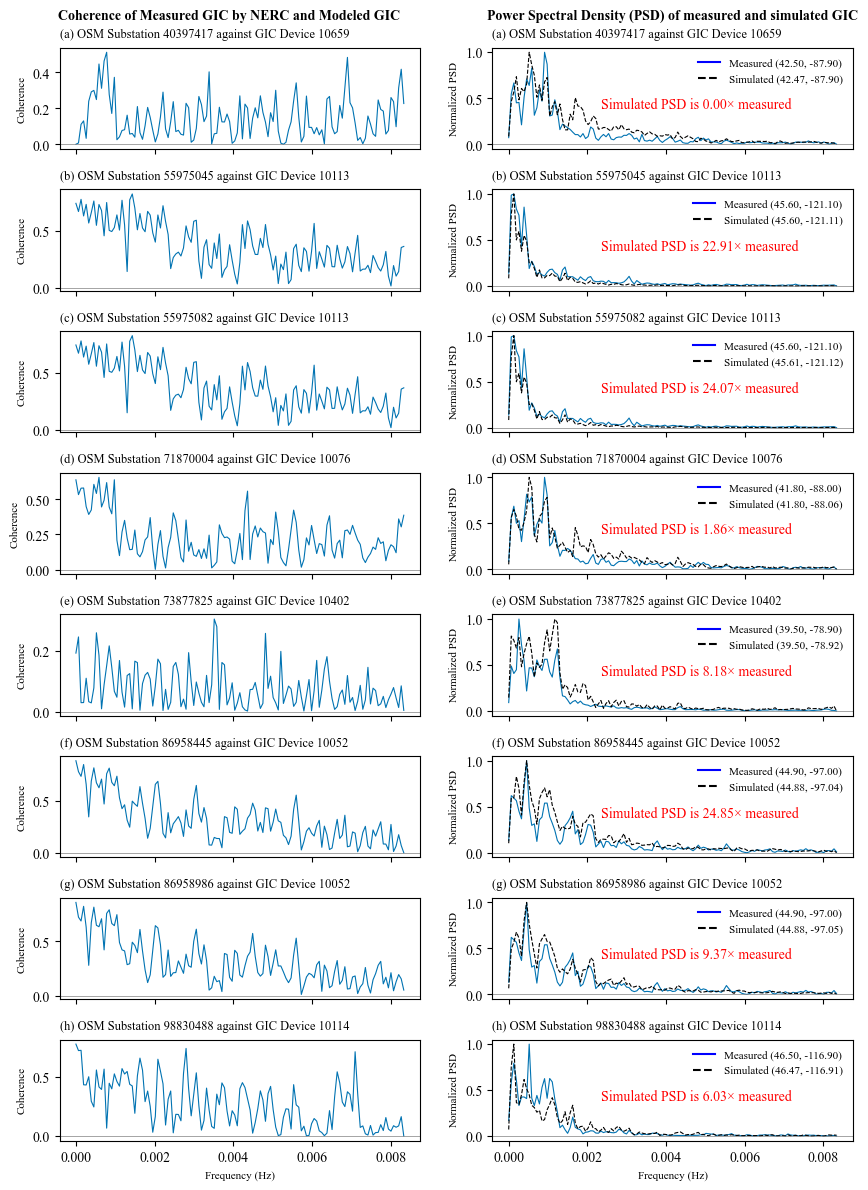

In [238]:
# NERC
fig_name= figures_dir / "gic_coherence_welch_nerc.png"
nerc=True
valid_match_ids, valid_dists, valid_substations, valid_dists, trafo_unique = find_close_matches(trafo_gic_gdf, ds_gic_nerc, site_ids, nerc=nerc, threshold=5)
plot_coherence_and_psd(ds_gic_nerc, trafo_unique, substation_names, valid_substations,
                            valid_match_ids, peak_times, uncertainty_arr,
                            mean_values, median_values,fig_name, nerc=nerc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 247.74it/s]


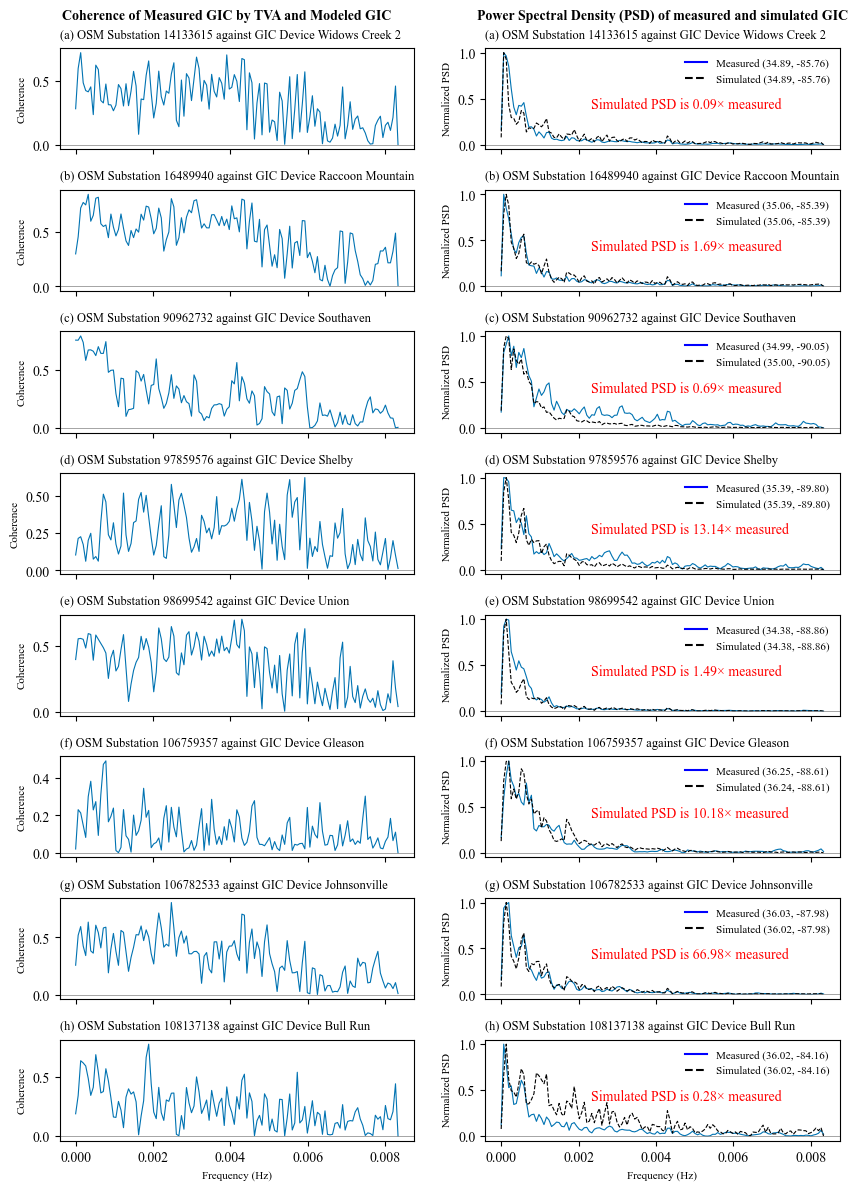

In [239]:
# TVA
fig_name= figures_dir / "gic_coherence_welch_tva.png"
nerc=False
valid_match_ids, valid_dists, valid_substations, valid_dists, trafo_unique = find_close_matches(trafo_gic_gdf, ds_gic_tva, site_ids, nerc=nerc, threshold=5)
plot_coherence_and_psd(ds_gic_tva, trafo_unique, substation_names, valid_substations,
                            valid_match_ids, peak_times, uncertainty_arr,
                            mean_values, median_values,fig_name, nerc=nerc)